In [1]:
from __future__ import (absolute_import, division, print_function)
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from folium import folium
from folium import features
from folium.plugins import TimeSliderChoropleth
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import numpy as np
import geocoder
import re

from shapely.geometry import Point
from shapely.geometry import Polygon
import pandas as pd
import geopandas as gpd
import seaborn as sns
#import contextily as ctx Needs Cartopy
from geopandas import GeoSeries, GeoDataFrame
%matplotlib inline

In [2]:
def get_lat_long(row, address = "Full Address", city = "CITY", state = "STATE"):
    string_list = []
    if row[address]:
        string_list.append(row[address])
    if row[city]:
        string_list.append(row[city])
    string_list.append("Los Angeles County")
    if row[state]:
        string_list.append(row[state])
    separator = ","
    full_string = separator.join(string_list)
    
    g = geocoder.arcgis(full_string)
    # Get latlng attribute from g
    # latlng is a list with two elements
    lat_lng_list = g.latlng
    #print(lat_lng_list)
    # Create default values for latitude and longitude
    latitude = 0.0
    longitude = 0.0
    # see if value returned by geocoder is within LA County
    # If so, replace default value with it
    if 33.6 <= lat_lng_list[0] <= 35.0:
        latitude = lat_lng_list[0]
    if -119.0 <= lat_lng_list[1] <= -117.6:
        longitude = lat_lng_list[1]
    # Populate the Lat and Long columns in the row
    #latitude = lat_lng_list[0]
    #longitude = lat_lng_list[1]
    row["Lat"] = latitude
    row["Long"] = longitude
    return row

In [3]:
#lat = re.compile('\d{2}\.\d*')
#long = re.compile('-\d*\.\d*')
# Regex with grouping to keep Lat and Long separate
latlong = re.compile('(\d{2}\.\d*), ?(-\d{3}\.\d*)')
#(34.0475, -118.323)

# Checks if Cross Street field is populated
# If so, combines with Address field and returns
# Otherwise returns original row
def combine_address_with_cross(row):
    if pd.notnull(row["Cross Street"]):
        combined_text = str(row["Address"]) + " and " + str(row["Cross Street"])
        row["Address"] = combined_text
        return row
    else:
        return row

# Checks if Location field has a null Lat/Long
# If so, runs combine_address_with_cross then geocodes result
# Returns geocoded row
def geocode_only_nulls(row, field, cross = True):
    if row[field] == "(0.0, 0.0)":
        if cross:
            row = combine_address_with_cross(row)
        geocoded_row = get_lat_long(row, address = "Address", city = "Area Name", state = "STATE")
        return geocoded_row
    else:
        return row
        
# Takes string location and searches for Lat Long using regex
# Checks to be sure result is within LA County
#def split_lat_long(row):
#    lat_long_str = row["Location"]
#    print(lat_long_str)
#    latitude = lat.search(lat_long_str)
#    #print(latitude.group())
#    if latitude:
#        if 33.6 <= float(latitude.group()) <= 35.0:
#            row["Lat"] = latitude.group()
#    else:
#        row["Lat"] = "No Match"
#   longitude = long.search(lat_long_str)
#    #print(longitude.group())
#    if longitude:
#        if -119.0 <= float(longitude.group()) <= -117.6:
#            row["Long"] = longitude.group()
#    else:
#        row["Long"] = "No Match"
#    return row

# Takes string location and searches for Lat Long using regex
# Checks to be sure result is within LA County
def split_lat_long(row, field):
    lat_long_str = row[field]
    #print(lat_long_str)
    #business_name = row["BUSINESS NAME"]
    #print(business_name)
    # Search Lat Long String with Regex
    latlongmatch = latlong.search(lat_long_str)
    # Check for match group 1 (Latitude)
    latitude = 0.0
    longitude = 0.0
    try:
        latitude = float(latlongmatch.group(1))
        #print("Latitude: " + str(latitude))
    except:
        pass
    # Check if returned latitude is within LA County Area
    try:
        if 33.6 <= latitude <= 35.0:
            row["Lat"] = latitude
    except:
        pass
    # Check for match group 2 (Longitude)
    try:
        longitude = float(latlongmatch.group(2))
        #print("Longitude: " + str(longitude))
    except:
        pass
    # Check if longitude is within LA County Area
    try:
        if -119.0 <= longitude <= -117.6:
            row["Long"] = longitude
    except:
        pass
    #print(str(row["Lat"]))
    #print(str(row["Long"]))
    return row

In [4]:
# Makes sure Lat Long Values are stored as floats
def convert_lat_long_to_float(row):
    row["Lat"] = float(row["Lat"])
    row["Long"] = float(row["Long"])
    return row

In [5]:
# Import arrest data from LAPD downloaded from City of LA Open Data Portal
raw_arrest_data = pd.read_csv("./Arrest_Data_from_2010_to_Present.csv", parse_dates = ["Arrest Date", "Time"])

In [6]:
raw_arrest_data.head()
#raw_arrest_data.shape
#raw_arrest_data["Charge Group Description"].unique()

,Report ID,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,Charge Group Code,Charge Group Description,Arrest Type Code,Charge,Charge Description,Address,Cross Street,Location
0,191811472,2019-05-03,1700,18,Southeast,1802,23,F,B,NaN,NaN,M,653.22 PC,NaN,91ST,FIGUEROA,"(33.9543, -118.2827)"
1,5614161,2019-04-29,1040,8,West LA,842,41,M,H,3.0,Robbery,F,211PC,ROBBERY,11600 WILSHIRE BL,NaN,"(34.0508, -118.4592)"
2,5615197,2019-04-30,0615,6,Hollywood,663,27,M,O,5.0,Burglary,F,459PC,BURGLARY,LA BREA,LEXINGTON,"(34.0907, -118.3384)"
3,5615701,2019-04-30,1100,9,Van Nuys,901,2,F,H,NaN,NaN,D,300(B)WIC,NaN,RAYMER,SEPULVEDA BL,"(34.2149, -118.4674)"
4,5615929,2019-04-30,1550,20,Olympic,2049,41,M,W,4.0,Aggravated Assault,F,245(A)(2)PC,ADW W/FIREARM,8TH ST,VERMONT,"(34.0578, -118.2916)"


In [7]:
raw_arrest_data["Charge Group Description"].unique()

array([nan, 'Robbery', 'Burglary', 'Aggravated Assault',
       'Miscellaneous Other Violations', 'Drunkeness', 'Larceny',
       'Liquor Laws', 'Narcotic Drug Laws', 'Disorderly Conduct',
       'Prostitution/Allied', 'Disturbing the Peace',
       'Driving Under Influence', 'Gambling', 'Sex (except rape/prst)',
       'Fraud/Embezzlement', 'Receive Stolen Property', 'Other Assaults',
       'Homicide', 'Weapon (carry/poss)', 'Vehicle Theft',
       'Against Family/Child', 'Forgery/Counterfeit',
       'Moving Traffic Violations', 'Non-Criminal Detention', 'Rape',
       'Federal Offenses', 'Pre-Delinquency'], dtype=object)

In [8]:
#Filter Raw Arrest Data to only DUI Incidents.
dui_arrest_data = raw_arrest_data[raw_arrest_data["Charge Group Description"] == 'Driving Under Influence']

In [9]:
# See how many we are left with
dui_arrest_data.shape

(120603, 17)

In [10]:
# Reset Index of Filtered Data
dui_arrest_data = dui_arrest_data.reset_index()

In [11]:
# Create empty rows to store Lat and Long
# Assign new row for state value
dui_arrest_data['Lat'] = np.nan
dui_arrest_data['Long'] = np.nan
dui_arrest_data = dui_arrest_data.assign(STATE="California")

In [12]:
# Confirm new rows added.
dui_arrest_data.shape

(120603, 21)

In [13]:
dui_arrest_data.head()

,index,Report ID,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,...,Charge Group Description,Arrest Type Code,Charge,Charge Description,Address,Cross Street,Location,Lat,Long,STATE
0,95,191008773,2019-04-20,1830,10,West Valley,1049,28,M,H,...,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,BURBANK BL,WOODLEY AV,"(34.1717, -118.4757)",NaN,NaN,California
1,183,5478957,2018-11-22,0940,8,West LA,827,21,F,W,...,Driving Under Influence,F,23153(A)VC,DUI ALCOHOL CAUSING INJURY,SAN VICENTE,BARRINGTON,"(34.0536, -118.4655)",NaN,NaN,California
2,202,5511360,2019-01-03,0116,7,Wilshire,717,39,M,B,...,Driving Under Influence,F,23153(A)VC,DUI ALCOHOL CAUSING INJURY,400 N LA BREA AV,NaN,"(34.0783, -118.3441)",NaN,NaN,California
3,213,5523557,2019-01-18,0150,7,Wilshire,784,35,M,B,...,Driving Under Influence,F,23153(A)VC,DUI ALCOHOL CAUSING INJURY,WASHINGTON BL,REDONDO ST,"(34.0412, -118.3528)",NaN,NaN,California
4,240,5551051,2019-02-19,1130,1,Central,122,38,F,W,...,Driving Under Influence,M,23152(B)VC,DRUNK DRIVING .10 OR ABOVE,100 N HILL ST,NaN,"(34.0572, -118.2481)",NaN,NaN,California


In [14]:
# Attempt to pull Lat Long from String values.
dui_arrest_data = dui_arrest_data.apply(split_lat_long, args=("Location",), axis = 1)

In [15]:
# Check for rows where Latitude is still null.
test_lat_long = dui_arrest_data[dui_arrest_data["Lat"].isnull()]
test_lat_long.shape

(187, 21)

In [16]:
# Rows missing a Latitude appear to be those with (0.0, 0.0)
test_lat_long.head()

,index,Report ID,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,...,Charge Group Description,Arrest Type Code,Charge,Charge Description,Address,Cross Street,Location,Lat,Long,STATE
147,2124,5613213,2019-04-28,0220,9,Van Nuys,995,29,F,W,...,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,SAN DIEGO FY,GETTY DR,"(0.0, 0.0)",NaN,NaN,California
677,8481,5638044,2019-05-24,0347,17,Devonshire,1733,27,M,H,...,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,HAYVENHURST,REGAN FY,"(0.0, 0.0)",NaN,NaN,California
4119,44027,5757800,2019-09-26,2127,14,Pacific,1400,23,M,H,...,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,10 FY,405 FY,"(0.0, 0.0)",NaN,NaN,California
5191,58615,2464438,2010-09-03,0330,9,Van Nuys,902,34,M,H,...,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,SEPULVEDA,GILMORE,"(0.0, 0.0)",NaN,NaN,California
5230,61341,2235703,2010-02-20,0030,2,Rampart,224,40,M,W,...,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,LA VETA TERRACE DR,SUNSET BL,"(0.0, 0.0)",NaN,NaN,California


In [17]:
# Run function to geocode rows with (0.0, 0.0) Lat Long
dui_arrest_data = dui_arrest_data.apply(geocode_only_nulls, args=("Location",), axis = 1)

In [18]:
# No longer have rows with Null Latitude
dui_arrest_data[dui_arrest_data["Lat"].isnull()]

,index,Report ID,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,...,Charge Group Description,Arrest Type Code,Charge,Charge Description,Address,Cross Street,Location,Lat,Long,STATE


In [19]:
# Make sure Lat Long values are float
dui_arrest_data = dui_arrest_data.apply(convert_lat_long_to_float, axis = 1)

In [20]:
dui_arrest_data["int_time"] = dui_arrest_data['Time'].astype(int)

In [21]:
dui_arrest_data.describe()

,index,Report ID,Area ID,Reporting District,Age,Charge Group Code,Lat,Long,int_time
count,1.206030e+05,1.206030e+05,120603.000000,120603.000000,120603.000000,120603.0,120603.000000,120603.000000,120603.000000
mean,8.380191e+05,4.069937e+06,11.307886,1179.200285,34.438231,22.0,34.095409,-118.363724,1117.277091
std,2.940283e+05,4.923199e+06,5.702602,572.085423,11.656282,0.0,0.107735,0.098771,900.166785
min,9.500000e+01,1.608103e+06,1.000000,100.000000,13.000000,22.0,33.706500,-118.666700,0.000000
25%,6.420675e+05,3.034826e+06,6.000000,667.000000,25.000000,22.0,34.027300,-118.437000,227.000000
50%,8.552080e+05,3.872868e+06,12.000000,1245.000000,31.000000,22.0,34.090800,-118.349500,1013.000000
75%,1.062324e+06,4.724706e+06,16.000000,1601.000000,42.000000,22.0,34.181700,-118.282050,2050.000000
max,1.314855e+06,1.921044e+08,21.000000,2199.000000,92.000000,22.0,34.706000,-117.716700,2400.000000


In [22]:
# Convert dataframe to geodataframe
dui_arrest_data_gdf = gpd.GeoDataFrame(
    dui_arrest_data, geometry=gpd.points_from_xy(dui_arrest_data.Long, dui_arrest_data.Lat))

# Convert Lat/Long data to projected Web Mercatur
dui_arrest_data_gdf.crs = {'init' :'epsg:4326'}
dui_arrest_data_gdf = dui_arrest_data_gdf.to_crs({'init': 'epsg:3857'})

In [23]:
# Filter to first 100 entries to run mapping test.
dui_arrest_data_gdf_for_mapping = dui_arrest_data_gdf.iloc[0:500]

In [24]:
# Load County outlines from LA Times
county = gpd.read_file("http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/counties-2012.geojson")
county = county.to_crs({'init': 'epsg:3857'})
# Filter to only display LA County
la_county = county[county["name"] == "Los Angeles"]
# Load City outline from LA Times
city = gpd.read_file("http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary/los-angeles-census-place-2012.geojson")
city = city.to_crs({'init': 'epsg:3857'})
freeways = gpd.read_file("./GISData/LosAngelesFreewaysAndRamps.geojson")
freeways = freeways.to_crs({'init': 'epsg:3857'})

In [25]:
city.head()

,kind,external_id,name,slug,set,metadata,resource_uri,geometry
0,Census Place (2012),Los Angeles,Los Angeles,los-angeles-census-place-2012,/1.0/boundary-set/census-places-2012/,"{'PCICBSA': 'Y', 'INTPTLAT': '+34.0193936', 'P...",/1.0/boundary/los-angeles-census-place-2012/,"MULTIPOLYGON (((-13210078.811 4053163.497, -13..."


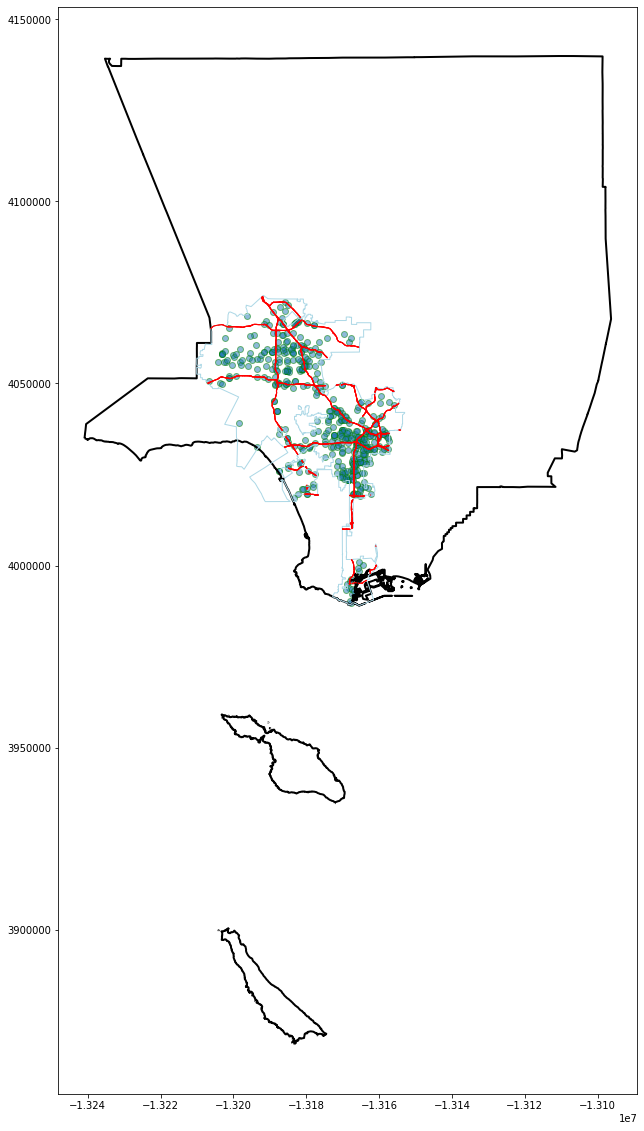

In [26]:
ax = la_county.geometry.boundary.plot(figsize=(20, 20),color=None,edgecolor='k',linewidth = 2)

#la_county.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 2,ax=ax)

city.geometry.boundary.plot(color=None,edgecolor='lightblue',linewidth = 1,ax=ax)

freeways.geometry.plot(color="Red", linewidth = 1, ax=ax)

dui_arrest_data_gdf_for_mapping.plot(figsize=(20, 20), alpha=0.5, edgecolor='green', ax = ax)

In [27]:
# Assembles List of Lists for Heat Map with Time plugin.
# Plugin currently not working, likely due to Leaflet update.
data_point_time_list=[]
# Create a list of 24 lists
# One for each hour of the day
for i in range(24):
    new_list = []
    data_point_time_list.append(new_list)
# Determine hour from Time and use as index to append to appropriate list
for index, row in dui_arrest_data_gdf.iterrows():
    time = row['Time']
    #print(time)
    hour = time[0:2]
    #Some data points list Midnight as 2400 while others list it as 0000
    if hour == '24':
        hour = '00'
    #print(int(hour))
    point = [row['Lat'],row['Long']]
    data_point_time_list[int(hour)].append(point)
    
#print(data_point_time_list)


In [28]:
my_map = folium.Map(location=[dui_arrest_data_gdf["Lat"].median(), dui_arrest_data_gdf["Long"].median()],
                       zoom_start=10, tiles='OpenStreetMap')

In [29]:
#HeatMapWithTime(data_point_time_list).add_to(my_map)

In [30]:
heat_data = [[row['Lat'],row['Long']] for index, row in dui_arrest_data_gdf_for_mapping.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(my_map)

# Display the map
my_map

In [31]:
new_map = folium.Map(location=[dui_arrest_data_gdf["Lat"].median(), dui_arrest_data_gdf["Long"].median()],
                       zoom_start=9, tiles='OpenStreetMap')

In [32]:
time_labels = ['Midnight - 1AM', '1AM to 2AM', '2AM to 3AM', '3AM to 4AM', '4AM to 5AM', '5AM to 6AM', '6AM to 7AM', '7AM to 8AM', '8AM to 9AM', '9AM to 10AM', '10AM to 11AM', '11AM to Noon', 'Noon to 1PM', '1PM - 2PM', '2PM - 3PM', '3PM - 4PM', '4PM - 5PM', '5PM - 6PM', '6PM - 7PM', '7PM - 8PM', '8PM - 9PM', '9PM - 10PM', '10PM - 11PM', '11PM - Midnight']
hm = plugins.HeatMapWithTime(data_point_time_list, index = time_labels, auto_play=True,max_opacity=0.8)

hm.add_to(new_map)
# Render the map
new_map.render()

In [33]:
# Jupyter Notebooks have difficulty displaying the map with so many data points. 
# Outputting to HTML file to view in browser separately.
new_map.save(outfile='index.html')

In [34]:
the_10 = gpd.read_file("./GISData/segments_for_buffering/10_downtown_to_405.geojson")
the_10 = the_10.to_crs({'init': 'epsg:3857'})

In [35]:
the_10_buffered = the_10
the_10_buffered["geometry"] = the_10.geometry.buffer(150)

In [36]:
the_10_buffered.head()

,FullName,Type,Elevation,Surface,Status,DrivingDir,From_L,From_R,To_L,To_R,...,LCity_R,NameCat_L,NameCat_R,Accuracy,Jurisdicti,Source,SourceID,UpdateDate,Shape_len,geometry
0,None,Ramp,Surface,Paved,Unrestricted,Two Way,0,0,0,0,...,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,141601629,2015-05-07,571.813145,"POLYGON ((-13174714.263 4033380.996, -13174716..."
1,None,Ramp,Surface,Paved,Unrestricted,Two Way,0,0,0,0,...,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,241170773,2015-05-07,151.341975,"POLYGON ((-13176692.643 4033407.255, -13176705..."
2,Interstate 10,Freeway,Surface,Paved,Unrestricted,Two Way,0,0,0,0,...,Los Angeles,Secondary,Secondary,50.0,UNKNOWN,TIGER Ramps And Free,241170751,2015-04-19,86.049217,"POLYGON ((-13170129.716 4033656.647, -13170144..."
3,Santa Monica Frwy,Freeway,Surface,Paved,Unrestricted,Two Way,0,0,0,0,...,Los Angeles,Primary,Primary,50.0,UNKNOWN,TIGER Ramps And Free,241170751,2015-04-19,86.049217,"POLYGON ((-13170129.716 4033656.647, -13170144..."
4,None,Ramp,Surface,Paved,Unrestricted,Two Way,0,0,0,0,...,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,241170699,2015-05-07,70.403895,"POLYGON ((-13175267.766 4033244.189, -13175282..."


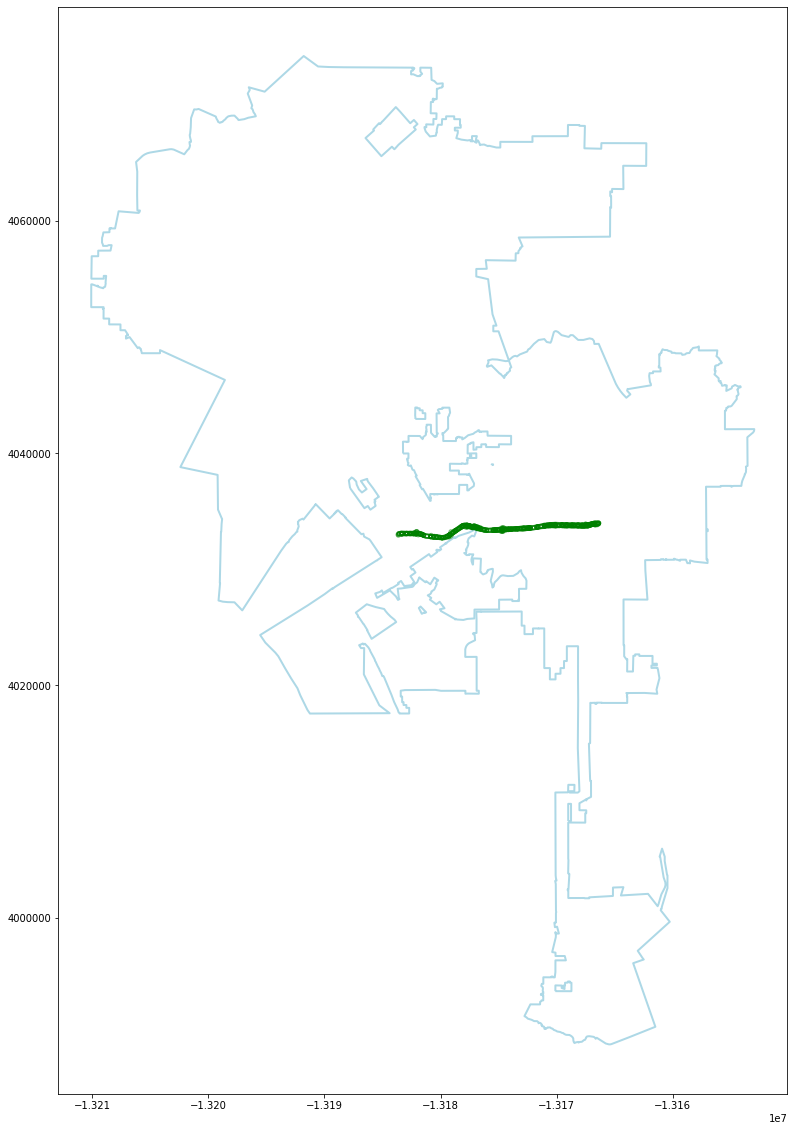

In [37]:
ax = city.geometry.boundary.plot(figsize=(20, 20),color=None,edgecolor='lightblue',linewidth = 2)

the_10_buffered.geometry.boundary.plot(alpha=0.5, edgecolor='green', ax = ax)

In [38]:
# Join DUI dataset to the freeway buffer.
join_duis_to_buffer = gpd.sjoin(dui_arrest_data_gdf, the_10_buffered, how='left', op='intersects', lsuffix='left', rsuffix='right')
# "Surface" field came from the buffer layer, so rows where it is null were outside the buffer
duis_on_the_10 = join_duis_to_buffer[join_duis_to_buffer["Surface"].notnull()]
print(duis_on_the_10.shape)
duis_on_the_10.head()

(28417, 56)


,index,Report ID,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,...,LCity_L,LCity_R,NameCat_L,NameCat_R,Accuracy,Jurisdicti,Source,SourceID,UpdateDate,Shape_len
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,241221193,2015-04-14,809.907539
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,Secondary,Secondary,50.0,UNKNOWN,TIGER Ramps And Free,142454034,2015-04-18,1131.852760
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,Primary,Primary,50.0,UNKNOWN,TIGER Ramps And Free,142454034,2015-04-18,1131.852760
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,141607343,2015-04-14,1031.813655
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,Secondary,Secondary,50.0,UNKNOWN,TIGER Ramps And Free,142454036,2015-04-18,1046.975440


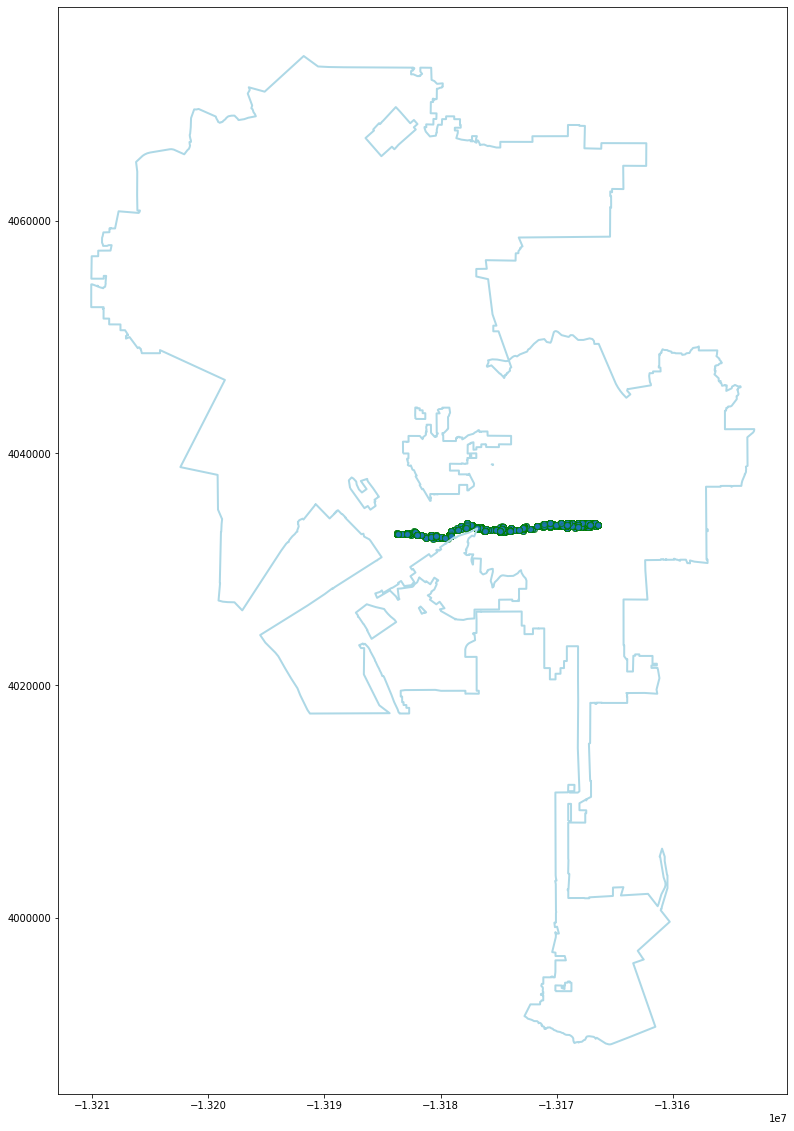

In [39]:
# Plot filtered dataset to make sure we're getting what we expect
ax = city.geometry.boundary.plot(figsize=(20, 20),color=None,edgecolor='lightblue',linewidth = 2)

duis_on_the_10.geometry.plot(alpha=0.5, edgecolor='green', ax = ax)

In [40]:
duis_on_the_10

,index,Report ID,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,...,LCity_L,LCity_R,NameCat_L,NameCat_R,Accuracy,Jurisdicti,Source,SourceID,UpdateDate,Shape_len
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,241221193,2015-04-14,809.907539
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,Secondary,Secondary,50.0,UNKNOWN,TIGER Ramps And Free,142454034,2015-04-18,1131.852760
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,Primary,Primary,50.0,UNKNOWN,TIGER Ramps And Free,142454034,2015-04-18,1131.852760
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,141607343,2015-04-14,1031.813655
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,Secondary,Secondary,50.0,UNKNOWN,TIGER Ramps And Free,142454036,2015-04-18,1046.975440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120538,1314495,5609065,2019-04-24,0306,20,Olympic,2093,25,M,H,...,Los Angeles,Los Angeles,Primary,Primary,50.0,UNKNOWN,TIGER Ramps And Free,141606019,2015-04-19,1188.676021
120538,1314495,5609065,2019-04-24,0306,20,Olympic,2093,25,M,H,...,Los Angeles,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,141606009,2015-04-19,442.955575
120538,1314495,5609065,2019-04-24,0306,20,Olympic,2093,25,M,H,...,Los Angeles,Los Angeles,Secondary,Secondary,50.0,UNKNOWN,TIGER Ramps And Free,241229778,2015-04-19,1090.484000
120538,1314495,5609065,2019-04-24,0306,20,Olympic,2093,25,M,H,...,Los Angeles,Los Angeles,Primary,Primary,50.0,UNKNOWN,TIGER Ramps And Free,241229778,2015-04-19,1090.484000


In [41]:
duis_on_the_10["Arrest Date"] = duis_on_the_10["Arrest Date"].astype("datetime64")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


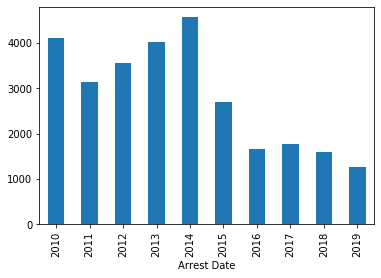

In [42]:
duis_on_the_10["Arrest Date"].groupby([duis_on_the_10["Arrest Date"].dt.year]).count().plot(kind="bar")

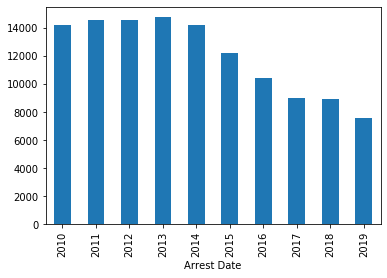

In [43]:
# Plot overall dui arrest data to compare with our area of interest.
dui_arrest_data["Arrest Date"].groupby([dui_arrest_data["Arrest Date"].dt.year]).count().plot(kind="bar")

# There is an overall downward trend in DUI's during the same timeframe.
## Is the change in our area of interest similar to the overall trend?

In [44]:
total_dui_by_year = dui_arrest_data["Arrest Date"].groupby([dui_arrest_data["Arrest Date"].dt.year]).count().astype(float)
total_dui_by_year

Arrest Date
2010    14193.0
2011    14584.0
2012    14574.0
2013    14775.0
2014    14248.0
2015    12244.0
2016    10468.0
2017     8992.0
2018     8918.0
2019     7607.0
Name: Arrest Date, dtype: float64

In [45]:
# Calculate % change year over year for total DUI's
total_change = (total_dui_by_year.pct_change())*100
total_change

Arrest Date
2010          NaN
2011     2.754879
2012    -0.068568
2013     1.379168
2014    -3.566836
2015   -14.065132
2016   -14.505064
2017   -14.100115
2018    -0.822954
2019   -14.700606
Name: Arrest Date, dtype: float64

In [46]:
i10_duis_by_year = duis_on_the_10["Arrest Date"].groupby([duis_on_the_10["Arrest Date"].dt.year]).count().astype(float)
i10_duis_by_year

Arrest Date
2010    4106.0
2011    3135.0
2012    3567.0
2013    4014.0
2014    4568.0
2015    2703.0
2016    1671.0
2017    1785.0
2018    1603.0
2019    1265.0
Name: Arrest Date, dtype: float64

In [47]:
aoi_change = (i10_duis_by_year.pct_change())*100
aoi_change

Arrest Date
2010          NaN
2011   -23.648320
2012    13.779904
2013    12.531539
2014    13.801694
2015   -40.827496
2016   -38.179800
2017     6.822262
2018   -10.196078
2019   -21.085465
Name: Arrest Date, dtype: float64

In [48]:
yearly_totals = pd.concat([total_dui_by_year, total_change, i10_duis_by_year, aoi_change], axis=1)
yearly_totals.columns=['Total DUI', 'Total Change', 'AOI DUI', 'AOI Change']
yearly_totals['Year'] = yearly_totals.index

In [49]:
yearly_totals.dropna()

,Total DUI,Total Change,AOI DUI,AOI Change,Year
Arrest Date,,,,,
2011,14584.0,2.754879,3135.0,-23.648320,2011
2012,14574.0,-0.068568,3567.0,13.779904,2012
2013,14775.0,1.379168,4014.0,12.531539,2013
2014,14248.0,-3.566836,4568.0,13.801694,2014
2015,12244.0,-14.065132,2703.0,-40.827496,2015
2016,10468.0,-14.505064,1671.0,-38.179800,2016
2017,8992.0,-14.100115,1785.0,6.822262,2017
2018,8918.0,-0.822954,1603.0,-10.196078,2018
2019,7607.0,-14.700606,1265.0,-21.085465,2019


In [50]:
yearly_totals["AOI DUI"].dtype

dtype('float64')

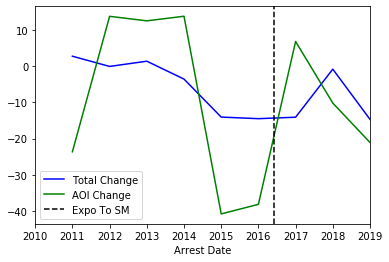

In [51]:
yearly_totals["Total Change"].plot(kind = "line", color='blue')
yearly_totals["AOI Change"].plot(kind = "line", color= 'green')
# Expo Line reached Santa Monica in May of 2016
# 5/12 = 0.4166666667 so using decimal to place marker line part way through the year.
plt.axvline(x=2016.4166666667, color= 'black', label = 'Expo To SM', linestyle = "--")
plt.legend()

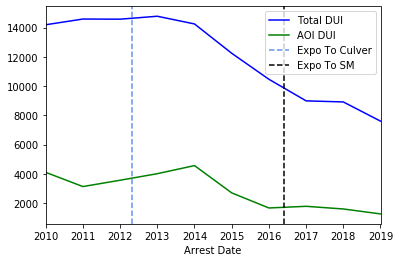

In [52]:
yearly_totals["Total DUI"].plot(kind = "line", color='blue')
yearly_totals["AOI DUI"].plot(kind = "line", color= 'green')
# Expo Line reached Santa Monica in May of 2016
# 5/12 = 0.4166666667 so using decimal to place marker line part way through the year.
plt.axvline(x=2012.3333333333, color= 'cornflowerblue', label = 'Expo To Culver', linestyle = "--")
plt.axvline(x=2016.4166666667, color= 'black', label = 'Expo To SM', linestyle = "--")

plt.legend(loc='upper right')

# Changes in the AOI are more extreme that overall changes. 
## The downward trend in DUI's also appears to start prior to the Expo Line reaching Santa Monica.
## Is this trend unique to this section of freeway?
## If not, is the change on the 10 Freeway comprable to changes on other freeway segments?

In [53]:
# Need to isolate DUI's in buffers of other freeways.
# Plot trend in each dataset together to compare.
# If Expo line isn't the source of the trend, what else could be a factor?
# How does the timing line up with the rise of Rideshare services?

### Need to bring in multiple layers
### Combining previous import into a function

In [54]:
def import_and_buffer(path, feet):
    gdf = gpd.read_file(path)
    gdf = gdf.to_crs({'init': 'epsg:3857'})
    buffered = gdf
    buffered["geometry"] = gdf.geometry.buffer(feet)
    return buffered

In [55]:
# Importing and Buffering Freeway Segments
# Using pronouns since this is LA
the_10 = import_and_buffer("./GISData/segments_for_buffering/10_downtown_to_405.geojson", 150)
the_5 = import_and_buffer("./GISData/segments_for_buffering/5_downtown_to_134.geojson", 150)
the_101 = import_and_buffer("./GISData/segments_for_buffering/101_downtown_to_north_hollywood.geojson", 150)
the_110 = import_and_buffer("./GISData/segments_for_buffering/110_downtown_to_pasadena.geojson", 150)
the_118 = import_and_buffer("./GISData/segments_for_buffering/118_from_405_to_ventura.geojson", 150)
the_405 = import_and_buffer("./GISData/segments_for_buffering/405_Sepulvida_Pass.geojson", 150)

In [56]:
# Addind the buffered segments to a dictionary so we can work with them as a group
segments = {}
segments["the_10"] = the_10
segments["the_5"] = the_5
segments["the_101"] = the_101
segments["the_110"] = the_110
segments["the_118"] = the_118
segments["the_405"] = the_405
#print(segments)

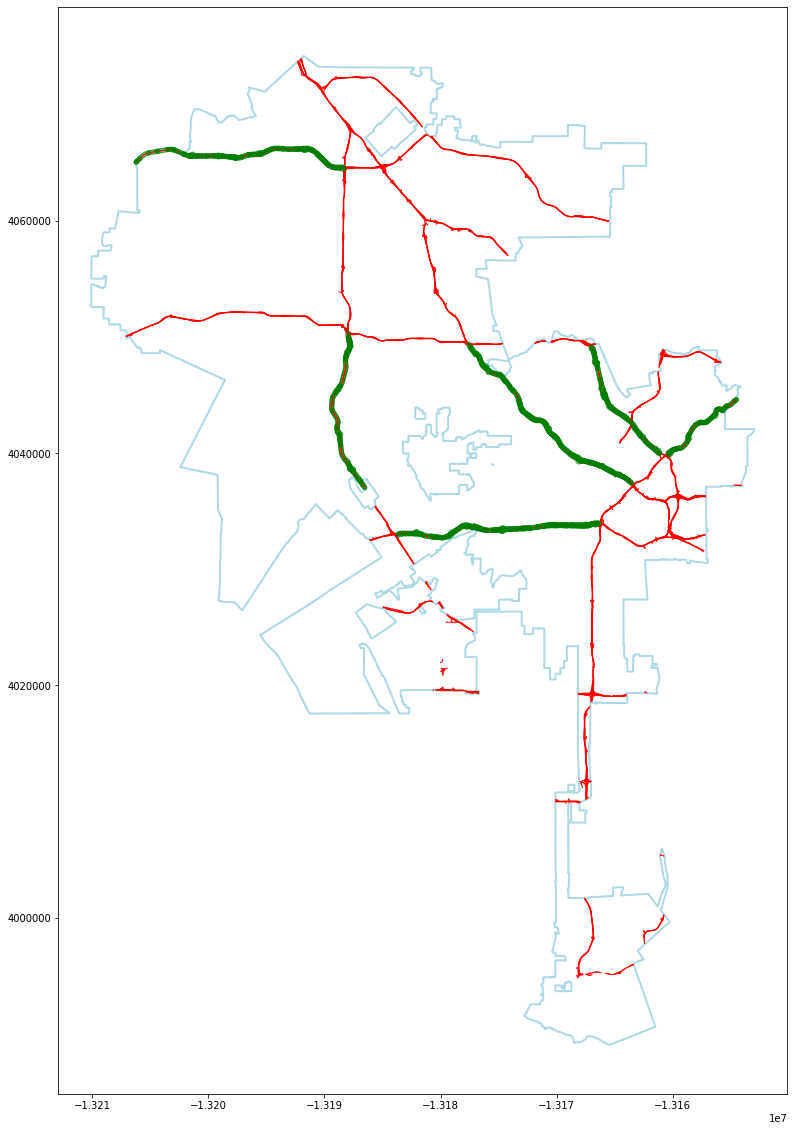

In [57]:
ax = city.geometry.boundary.plot(figsize=(20, 20),color=None,edgecolor='lightblue',linewidth = 2)
freeways.geometry.plot(color="Red", linewidth = 1, ax=ax)

for freeway in segments.values():
    freeway.geometry.boundary.plot(alpha=0.5, edgecolor='green', ax = ax)

In [58]:
# Join DUI dataset to the freeway buffer.
join_duis_to_buffer = gpd.sjoin(dui_arrest_data_gdf, the_10, how='left', op='intersects', lsuffix='left', rsuffix='right')
# "Surface" field came from the buffer layer, so rows where it is null were outside the buffer
duis_on_the_10 = join_duis_to_buffer[join_duis_to_buffer["Surface"].notnull()]
print(duis_on_the_10.shape)
duis_on_the_10.head()

(28417, 56)


,index,Report ID,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,...,LCity_L,LCity_R,NameCat_L,NameCat_R,Accuracy,Jurisdicti,Source,SourceID,UpdateDate,Shape_len
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,241221193,2015-04-14,809.907539
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,Secondary,Secondary,50.0,UNKNOWN,TIGER Ramps And Free,142454034,2015-04-18,1131.852760
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,Primary,Primary,50.0,UNKNOWN,TIGER Ramps And Free,142454034,2015-04-18,1131.852760
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,141607343,2015-04-14,1031.813655
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,Secondary,Secondary,50.0,UNKNOWN,TIGER Ramps And Free,142454036,2015-04-18,1046.975440


In [59]:
dui_dict = {}

for name, freeway in segments.items():
    print("Freeway Pulled")
    join_to_duis = gpd.sjoin(dui_arrest_data_gdf, freeway, how='left', op='intersects', lsuffix='left', rsuffix='right')
    duis_selected = join_to_duis[join_to_duis["Surface"].notnull()]
    print("DUIs Selected")
    print(duis_selected)
    dui_dict[name]= duis_selected
    

Freeway Pulled
DUIs Selected
          index  Report ID Arrest Date  Time  Area ID  Area Name  \
78         1455    5613205  2019-04-28  0425        3  Southwest   
78         1455    5613205  2019-04-28  0425        3  Southwest   
78         1455    5613205  2019-04-28  0425        3  Southwest   
78         1455    5613205  2019-04-28  0425        3  Southwest   
78         1455    5613205  2019-04-28  0425        3  Southwest   
...         ...        ...         ...   ...      ...        ...   
120538  1314495    5609065  2019-04-24  0306       20    Olympic   
120538  1314495    5609065  2019-04-24  0306       20    Olympic   
120538  1314495    5609065  2019-04-24  0306       20    Olympic   
120538  1314495    5609065  2019-04-24  0306       20    Olympic   
120538  1314495    5609065  2019-04-24  0306       20    Olympic   

        Reporting District  Age Sex Code Descent Code  ...      LCity_L  \
78                     309   31        M            H  ...  Los Angeles   
78  

DUIs Selected
          index  Report ID Arrest Date  Time  Area ID   Area Name  \
31         1159    5612028  2019-04-26  2225       11   Northeast   
943       10749    5644845  2019-05-31  0042        4  Hollenbeck   
943       10749    5644845  2019-05-31  0042        4  Hollenbeck   
943       10749    5644845  2019-05-31  0042        4  Hollenbeck   
943       10749    5644845  2019-05-31  0042        4  Hollenbeck   
...         ...        ...         ...   ...      ...         ...   
120350  1313352    5599935  2019-04-13  2310        4  Hollenbeck   
120431  1313926    5612254  2019-04-26  2355       11   Northeast   
120445  1314002    5612020  2019-04-26  2230       11   Northeast   
120465  1314111    5612301  2019-04-27  0100       11   Northeast   
120490  1314252    5611977  2019-04-26  2120       11   Northeast   

        Reporting District  Age Sex Code Descent Code  ...      LCity_L  \
31                    1177   39        M            H  ...  Los Angeles   
943    

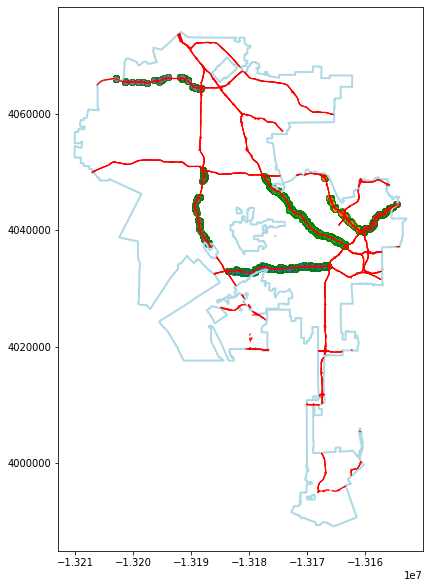

In [60]:
ax = city.geometry.boundary.plot(figsize=(10, 10),color=None,edgecolor='lightblue',linewidth = 2)
freeways.geometry.plot(color="Red", linewidth = 1, ax=ax)

for points in dui_dict.values():
    points.geometry.plot(alpha=0.5, edgecolor='green', ax = ax)


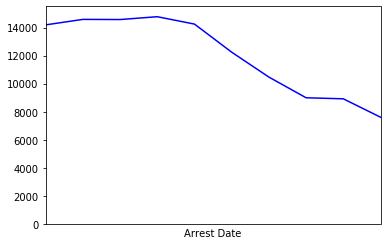

In [61]:
dui_arrest_data["Arrest Date"].groupby([dui_arrest_data["Arrest Date"].dt.year]).count().plot(kind="bar")
yearly_totals["Total DUI"].plot(kind = "line", color='blue')

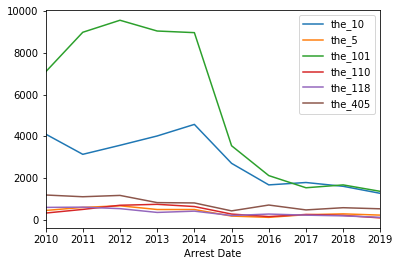

In [62]:
for name, points in dui_dict.items():
    points["Arrest Date"].groupby([points["Arrest Date"].dt.year]).count().plot(kind="line", label = name)
plt.legend(loc='upper right')

In [63]:
neighborhoods = gpd.read_file("./GISData/Neighborhood_Councils_Certified/Neighborhood_Councils_Certified.shp")
neighborhoods = neighborhoods.to_crs({'init': 'epsg:3857'})
neighborhoods.head()

,OBJECTID,NAME,WADDRESS,DWEBSITE,DEMAIL,DPHONE,NC_ID,CERTIFIED,TOOLTIP,NLA_URL,SERVICE_RE,geometry
0,1,LINCOLN HEIGHTS NC,http://www.lincolnheightsnc.org/,http://empowerla.org/LHNC,LHNC@EmpowerLA.org,213-978-1551,47,2002-04-27T00:00:00.000Z,LINCOLN HEIGHTS NC,navigatela/reports/nc_reports.cfm?id=47,REGION 8 - NORTH EAST LA,"POLYGON ((-13158524.586 4036268.663, -13158638..."
1,2,VOICES OF 90037,https://www.voicesnc.org,https://empowerla.org/voicesof90037/,V9NC@EmpowerLA.org,213-978-1551,109,2008-06-16T00:00:00.000Z,VOICES OF 90037,navigatela/reports/nc_reports.cfm?id=109,REGION 9 - SOUTH LA 2,"POLYGON ((-13167174.935 4030298.989, -13167131..."
2,3,LOS FELIZ NC,http://www.losfeliznc.org/,http://empowerla.org/LFNC,LFNC@EmpowerLA.org,213-978-1551,36,2002-06-11T00:00:00.000Z,LOS FELIZ NC,navigatela/reports/nc_reports.cfm?id=36,REGION 7 - EAST,"POLYGON ((-13169127.631 4050028.421, -13168966..."
3,4,MISSION HILLS NC,http://mhnconline.org/,http://empowerla.org/MHNC,MHNC@EmpowerLA.org,213-978-1551,101,2005-04-19T00:00:00.000Z,MISSION HILLS NC,navigatela/reports/nc_reports.cfm?id=101,REGION 1 - NORTH EAST VALLEY,"POLYGON ((-13187947.126 4066529.147, -13187944..."
4,5,GREATER TOLUCA LAKE NC,http://www.gtlnc.org/,http://empowerla.org/GTLNC,GTLNC@EmpowerLA.org,213-978-1551,28,2002-09-10T00:00:00.000Z,GREATER TOLUCA LAKE NC,navigatela/reports/nc_reports.cfm?id=28,REGION 4 - SOUTH EAST VALLEY,"POLYGON ((-13175241.903 4050967.615, -13175252..."


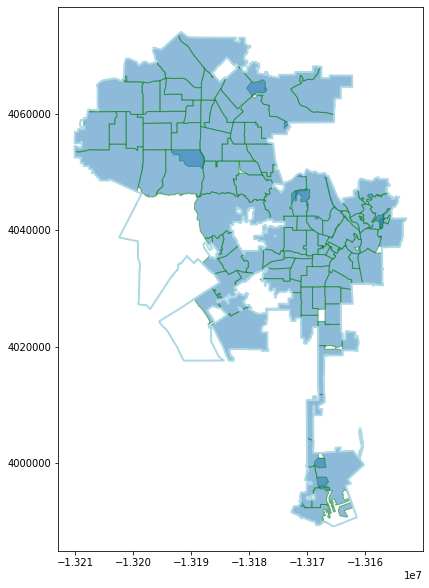

In [64]:
ax = city.geometry.boundary.plot(figsize=(10, 10),color=None,edgecolor='lightblue',linewidth = 2)
neighborhoods.geometry.plot(alpha=0.5, edgecolor='green', ax = ax)

In [65]:
dui_neighborhood_dict = {}

# For each row in the neighborhood DF, store the name as a variable and create a new DF of just that neighborhood.
# Join the Neighborhood DF to the dui DF and store the result in the dictionary with neighborhood name as key
for index, row in neighborhoods.iterrows():
    name = row["NAME"]
    neighborhood_df = neighborhoods[neighborhoods["NAME"] == name]
    join_to_duis = gpd.sjoin(dui_arrest_data_gdf, neighborhood_df, how='right', op='intersects', lsuffix='left', rsuffix='right')
    #print("DUIs Selected")
    #print(join_to_duis.head())
    dui_neighborhood_dict[name]= join_to_duis
    

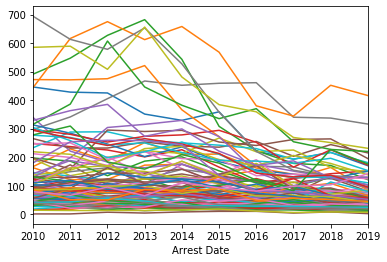

In [66]:
for name, points in dui_neighborhood_dict.items():
    points["Arrest Date"].groupby([points["Arrest Date"].dt.year]).count().plot(kind="line", label = name)
#plt.legend(loc='upper right')

In [67]:
# Too Much data for a graph to effectively communicate. Try a chloropleth map.
# Add Column to neighborhoods gdf and calculate area.
# Select DUI's in each neighborhood and select by year. Populate column with DUI's/sqkm
neighborhoods["Area"] = neighborhoods["geometry"].area/1000000

In [68]:
# CRS uses meters, so Area should be in Square Meters
# Multiply by 1,000,000 above to get square kilometers
neighborhoods.crs

{'init': 'epsg:3857'}

In [69]:
#Creating Columns to Hold Annual DUI Statistics
nan_value = float("NaN")
neighborhoods["2010"] = nan_value
neighborhoods["2011"] = nan_value
neighborhoods["2012"] = nan_value
neighborhoods["2013"] = nan_value
neighborhoods["2014"] = nan_value
neighborhoods["2015"] = nan_value
neighborhoods["2016"] = nan_value
neighborhoods["2017"] = nan_value
neighborhoods["2018"] = nan_value
neighborhoods["2019"] = nan_value
neighborhoods.head()

,OBJECTID,NAME,WADDRESS,DWEBSITE,DEMAIL,DPHONE,NC_ID,CERTIFIED,TOOLTIP,NLA_URL,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,1,LINCOLN HEIGHTS NC,http://www.lincolnheightsnc.org/,http://empowerla.org/LHNC,LHNC@EmpowerLA.org,213-978-1551,47,2002-04-27T00:00:00.000Z,LINCOLN HEIGHTS NC,navigatela/reports/nc_reports.cfm?id=47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,VOICES OF 90037,https://www.voicesnc.org,https://empowerla.org/voicesof90037/,V9NC@EmpowerLA.org,213-978-1551,109,2008-06-16T00:00:00.000Z,VOICES OF 90037,navigatela/reports/nc_reports.cfm?id=109,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,LOS FELIZ NC,http://www.losfeliznc.org/,http://empowerla.org/LFNC,LFNC@EmpowerLA.org,213-978-1551,36,2002-06-11T00:00:00.000Z,LOS FELIZ NC,navigatela/reports/nc_reports.cfm?id=36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,MISSION HILLS NC,http://mhnconline.org/,http://empowerla.org/MHNC,MHNC@EmpowerLA.org,213-978-1551,101,2005-04-19T00:00:00.000Z,MISSION HILLS NC,navigatela/reports/nc_reports.cfm?id=101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,GREATER TOLUCA LAKE NC,http://www.gtlnc.org/,http://empowerla.org/GTLNC,GTLNC@EmpowerLA.org,213-978-1551,28,2002-09-10T00:00:00.000Z,GREATER TOLUCA LAKE NC,navigatela/reports/nc_reports.cfm?id=28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
def calculate_annual_duis_per_sqkm(row):
    name = row["NAME"]
    neighborhood_gdf = neighborhoods[neighborhoods["NAME"] == name]
    neighborhood_duis = gpd.sjoin(neighborhood_gdf, dui_arrest_data_gdf, how='left', op='intersects', lsuffix='left', rsuffix='right')
    years = ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019"]
    for year in years:
        annual_dui = neighborhood_duis[neighborhood_duis["Arrest Date"].dt.year == int(year)]
        annual_total = len(annual_dui.index)
        annual_normalized = annual_total/row["Area"]
        row[year] = annual_normalized
    return row
    
#DataFrame.apply(self, func, axis=0,

In [71]:
neighborhoods_populated = neighborhoods.apply(calculate_annual_duis_per_sqkm, axis=1)

In [72]:
neighborhoods_populated.head()

,OBJECTID,NAME,WADDRESS,DWEBSITE,DEMAIL,DPHONE,NC_ID,CERTIFIED,TOOLTIP,NLA_URL,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,1,LINCOLN HEIGHTS NC,http://www.lincolnheightsnc.org/,http://empowerla.org/LHNC,LHNC@EmpowerLA.org,213-978-1551,47,2002-04-27T00:00:00.000Z,LINCOLN HEIGHTS NC,navigatela/reports/nc_reports.cfm?id=47,...,5.328365,4.495808,8.908361,4.828831,5.161854,4.912087,4.579064,5.328365,4.912087,3.746507
1,2,VOICES OF 90037,https://www.voicesnc.org,https://empowerla.org/voicesof90037/,V9NC@EmpowerLA.org,213-978-1551,109,2008-06-16T00:00:00.000Z,VOICES OF 90037,navigatela/reports/nc_reports.cfm?id=109,...,20.271584,27.797561,22.699318,30.468069,25.369826,25.612600,19.664650,16.994142,16.265822,15.173341
2,3,LOS FELIZ NC,http://www.losfeliznc.org/,http://empowerla.org/LFNC,LFNC@EmpowerLA.org,213-978-1551,36,2002-06-11T00:00:00.000Z,LOS FELIZ NC,navigatela/reports/nc_reports.cfm?id=36,...,2.163471,2.019239,2.105778,3.634631,2.423087,1.644238,1.384621,1.240390,1.471160,0.865388
3,4,MISSION HILLS NC,http://mhnconline.org/,http://empowerla.org/MHNC,MHNC@EmpowerLA.org,213-978-1551,101,2005-04-19T00:00:00.000Z,MISSION HILLS NC,navigatela/reports/nc_reports.cfm?id=101,...,7.240770,8.557274,7.313909,6.728797,6.509379,7.094492,9.142387,6.655658,4.754041,5.046598
4,5,GREATER TOLUCA LAKE NC,http://www.gtlnc.org/,http://empowerla.org/GTLNC,GTLNC@EmpowerLA.org,213-978-1551,28,2002-09-10T00:00:00.000Z,GREATER TOLUCA LAKE NC,navigatela/reports/nc_reports.cfm?id=28,...,13.696523,12.818541,16.857259,15.276891,15.276891,11.940558,6.672665,7.550647,4.916701,6.321472


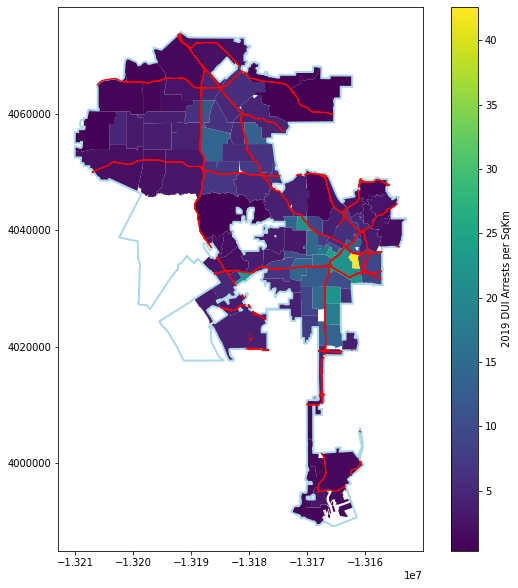

In [73]:
ax = city.geometry.boundary.plot(figsize=(10, 10),color=None,edgecolor='lightblue',linewidth = 2)
neighborhoods_populated.plot(column='2019',ax=ax, legend=True, legend_kwds={'label': "2019 DUI Arrests per SqKm"})
freeways.geometry.plot(color="Red", linewidth = 1, ax=ax)

In [74]:
#df.sort_values(by='col1', ascending=False)
neighborhoods_populated.sort_values(by='2019', ascending=False)

,OBJECTID,NAME,WADDRESS,DWEBSITE,DEMAIL,DPHONE,NC_ID,CERTIFIED,TOOLTIP,NLA_URL,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
96,103,HISTORIC CULTURAL NC,http://www.hcncla.org/,http://empowerla.org/HCNC,HCNC@EmpowerLA.org,213-978-1551,46,2002-04-27T00:00:00.000Z,HISTORIC CULTURAL NC,navigatela/reports/nc_reports.cfm?id=46,...,23.678237,19.781818,28.473829,19.482094,33.269422,27.574656,24.277686,29.373003,30.871625,42.560882
64,65,WESTLAKE SOUTH NC,https://www.wsncla.org,https://empowerla.org/wsnc/,WSNC@EmpowerLA.org,213-978-1551,121,2011-06-07T00:00:00.000Z,WESTLAKE SOUTH NC,navigatela/reports/nc_reports.cfm?id=121,...,32.210875,32.210875,33.302769,31.664928,42.037922,34.394663,41.491975,27.297352,20.745987,24.021670
69,70,PALMS NC,http://palmsla.org/,http://empowerla.org/PALMSNC,PalmsNC@EmpowerLA.org,213-978-1551,115,2004-12-14T00:00:00.000Z,PALMS NC,navigatela/reports/nc_reports.cfm?id=115,...,18.429146,17.312228,17.032998,17.870687,12.286097,15.357621,10.889950,11.727638,31.552931,22.338358
92,93,ZAPATA KING NC,http://www.zapatakingnc.org/,http://empowerla.org/ZKNC,None,213-978-1551,125,2015-02-03T00:00:00.000Z,ZAPATA KING NC,navigatela/reports/nc_reports.cfm?id=125,...,34.997044,38.899592,23.037622,19.890406,26.310727,22.534068,14.980749,10.322869,28.576723,22.156402
71,72,DOWNTOWN LOS ANGELES,http://dlanc.com/,http://empowerla.org/DLANC,DLANC@EmpowerLA.org,213-978-1551,52,2002-04-27T00:00:00.000Z,DOWNTOWN LOS ANGELES,navigatela/reports/nc_reports.cfm?id=52,...,23.302112,32.329056,35.425508,32.119127,34.533310,29.809909,19.943249,18.053889,23.721970,21.832609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,46,PORTER RANCH NC,http://www.prnc.org/,http://empowerla.org/PRNC,PRNC@EmpowerLA.org,213-978-1551,114,2003-07-01T00:00:00.000Z,PORTER RANCH NC,navigatela/reports/nc_reports.cfm?id=114,...,1.916064,1.824822,1.094893,1.231755,1.094893,1.186135,1.049273,1.049273,0.729929,0.729929
76,77,BEL AIR-BEVERLY CREST NC,http://babcnc.org/,http://empowerla.org/BABCNC,BABCNC@EmpowerLA.org,213-978-1551,64,2002-10-08T00:00:00.000Z,BEL AIR-BEVERLY CREST NC,navigatela/reports/nc_reports.cfm?id=64,...,0.776092,0.496699,0.698483,0.667439,0.543265,0.558786,0.589830,0.419090,0.512221,0.636396
41,42,WEST HILLS NC,http://www.westhillsnc.org/,http://empowerla.org/WHNC,WHNC@EmpowerLA.org,213-978-1551,11,2002-01-22T00:00:00.000Z,WEST HILLS NC,navigatela/reports/nc_reports.cfm?id=11,...,0.846833,1.326706,0.903289,1.157339,1.044428,1.016200,1.185567,1.016200,0.762150,0.564556
8,9,FOOTHILL TRAILS DISTRICT NC,http://www.ftdnc.org/,http://empowerla.org/FTDNC,FTDNC@EmpowerLA.org,213-978-1551,9,2003-03-25T00:00:00.000Z,FOOTHILL TRAILS DISTRICT NC,navigatela/reports/nc_reports.cfm?id=9,...,0.938658,0.857036,0.625772,0.598565,0.884243,0.789017,0.775414,0.666584,0.789017,0.421716


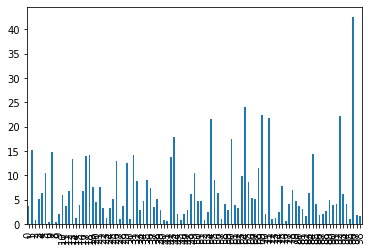

In [75]:
neighborhoods_populated["2019"].plot(kind="bar")

In [76]:
# Plot 2019 DUI Arrests in the neighborhood with the most.
# HISTORIC CULTURAL NC
historic_cultural_gdf = neighborhoods[neighborhoods["NAME"] == "HISTORIC CULTURAL NC"]
historic_cultural_gdf = historic_cultural_gdf.reset_index()
polygon = historic_cultural_gdf.geometry[0]
hcnc_duis = dui_arrest_data_gdf[dui_arrest_data_gdf.within(polygon)]
#print(hcnc_duis.count)
hcnc_duis_2019 = hcnc_duis[hcnc_duis["Arrest Date"].dt.year == 2019]
hcnc_duis_nov_2019 = hcnc_duis[(hcnc_duis["Arrest Date"].dt.year == 2019) & (hcnc_duis["Arrest Date"].dt.month == 11)]



In [77]:
hcnc_duis_2019.describe()

,index,Report ID,Area ID,Reporting District,Age,Charge Group Code,Lat,Long,int_time
count,1.420000e+02,1.420000e+02,142.0,142.000000,142.000000,142.0,142.000000,142.000000,142.000000
mean,4.506999e+05,5.654644e+06,1.0,138.570423,35.197183,22.0,34.047164,-118.239810,1481.014085
std,6.013809e+05,8.766241e+04,0.0,14.742421,13.033095,0.0,0.005666,0.003014,639.551183
min,9.790000e+02,5.333676e+06,1.0,127.000000,17.000000,22.0,34.034800,-118.243800,30.000000
25%,2.101700e+04,5.582327e+06,1.0,127.000000,25.000000,22.0,34.041850,-118.242400,1120.000000
50%,4.185700e+04,5.666372e+06,1.0,128.000000,32.000000,22.0,34.051300,-118.240000,1427.500000
75%,1.297738e+06,5.727664e+06,1.0,158.000000,43.750000,22.0,34.051500,-118.238250,2113.000000
max,1.313987e+06,5.800714e+06,1.0,159.000000,79.000000,22.0,34.053000,-118.230500,2356.000000


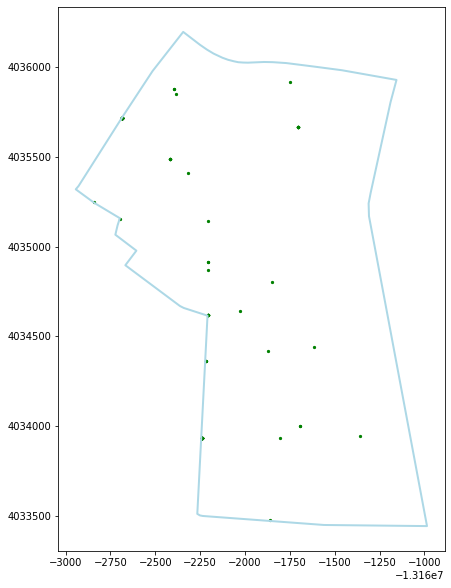

In [78]:
ax = historic_cultural_gdf.geometry.boundary.plot(figsize=(10, 10),color=None,edgecolor='lightblue',linewidth = 2)
#freeways.geometry.plot(color="Red", linewidth = 1, ax=ax)
#historic_cultural_gdf.plot(color=None,edgecolor='darkblue',linewidth = 1, ax=ax)
hcnc_duis_2019.plot(color="Green", markersize = 5,  ax=ax)
#active_alcohol_gdf.plot(color="Blue", ax=ax)

In [79]:
#hcnc_outline_coords = historic_cultural_gdf.geometry.to_list()
coordinates_array = np.asarray(historic_cultural_gdf.exterior)
print(coordinates_array)

## There are a lot of overlapping data points. A heat map will be better to display.

In [80]:
nc_map = folium.Map(location=[hcnc_duis_2019["Lat"].median(), hcnc_duis_2019["Long"].median()],
                       zoom_start=15, tiles='OpenStreetMap')


In [81]:
nc_heat_data = [[row['Lat'],row['Long']] for index, row in hcnc_duis_2019.iterrows()]

#folium.vector_layers.Polygon(locations, popup=None, tooltip=None, **kwargs)¶
nc_geojson = historic_cultural_gdf.to_json()
#nc_outline = folium.features.Chloropleth(nc_geojson)
#nc_map.add_children(nc_outline)
# Plot it on the map
HeatMap(nc_heat_data).add_to(nc_map)

# Display the map
nc_map

In [82]:
# Examine change from 2013 to 2016
# See what parts of the city it was concentrated in
# Subtracting more recent data from older so that increases in rate will show as a positive value and vice versa.
neighborhoods_populated["Change_2010-2019"] = neighborhoods_populated["2019"] - neighborhoods_populated["2010"]
neighborhoods_populated["Change_2013-2016"] = neighborhoods_populated["2016"] - neighborhoods_populated["2010"]

In [83]:
neighborhoods_populated.sort_values(by='Change_2010-2019', ascending=False)

,OBJECTID,NAME,WADDRESS,DWEBSITE,DEMAIL,DPHONE,NC_ID,CERTIFIED,TOOLTIP,NLA_URL,...,2012,2013,2014,2015,2016,2017,2018,2019,Change_2010-2019,Change_2013-2016
96,103,HISTORIC CULTURAL NC,http://www.hcncla.org/,http://empowerla.org/HCNC,HCNC@EmpowerLA.org,213-978-1551,46,2002-04-27T00:00:00.000Z,HISTORIC CULTURAL NC,navigatela/reports/nc_reports.cfm?id=46,...,28.473829,19.482094,33.269422,27.574656,24.277686,29.373003,30.871625,42.560882,18.882645,0.599449
49,50,OLYMPIC PARK NC,http://opnc.org/,http://empowerla.org/OPNC,OPNC@EmpowerLA.org,213-978-1551,104,2003-12-02T00:00:00.000Z,OLYMPIC PARK NC,navigatela/reports/nc_reports.cfm?id=104,...,7.241223,9.343513,8.876337,8.642750,14.949621,9.810689,13.781682,10.511452,4.204581,8.642750
69,70,PALMS NC,http://palmsla.org/,http://empowerla.org/PALMSNC,PalmsNC@EmpowerLA.org,213-978-1551,115,2004-12-14T00:00:00.000Z,PALMS NC,navigatela/reports/nc_reports.cfm?id=115,...,17.032998,17.870687,12.286097,15.357621,10.889950,11.727638,31.552931,22.338358,3.909213,-7.539196
63,64,WESTLAKE NORTH NC,https://www.westlakenorthnc.org,https://empowerla.org/wnnc/,WNNC@EmpowerLA.org,213-978-1551,97,2011-06-07T00:00:00.000Z,WESTLAKE NORTH NC,navigatela/reports/nc_reports.cfm?id=97,...,15.215808,11.543027,22.036687,17.314540,10.493661,9.968978,11.543027,9.968978,2.623415,3.148098
21,22,ELYSIAN VALLEY RIVERSIDE NC,NULL,http://empowerla.org/EVRNC,EVRNC@EmpowerLA.org,213-978-1551,43,2002-07-09T00:00:00.000Z,ELYSIAN VALLEY RIVERSIDE NC,navigatela/reports/nc_reports.cfm?id=43,...,12.745148,7.647089,8.375383,5.462206,4.733912,6.918795,10.924413,7.647089,2.184883,-0.728294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,78,HOLLYWOOD HILLS WEST NC,http://www.hhwnc.org/,http://empowerla.org/HHWNC,HHWNC@EmpowerLA.org,213-978-1551,29,2002-05-07T00:00:00.000Z,HOLLYWOOD HILLS WEST NC,navigatela/reports/nc_reports.cfm?id=29,...,18.264822,20.634825,16.653220,11.312814,6.952009,4.866406,4.234405,4.076405,-17.854022,-14.978418
12,13,NOHO NC,http://www.midtownnoho.org/,http://empowerla.org/NOHONC,MTNHNC@EmpowerLA.org,213-978-1551,24,2002-09-24T00:00:00.000Z,NOHO NC,navigatela/reports/nc_reports.cfm?id=24,...,34.906322,37.968280,30.229877,17.146965,12.414848,9.909610,9.519906,6.736308,-20.598627,-14.920086
36,37,NC VALLEY VILLAGE,http://www.myvalleyvillage.com/,http://empowerla.org/NCVV,NCVV@EmpowerLA.org,213-978-1551,25,2002-09-10T00:00:00.000Z,NC VALLEY VILLAGE,navigatela/reports/nc_reports.cfm?id=25,...,22.951987,29.528872,21.475543,13.824881,9.798217,6.308441,7.516440,7.382218,-21.072877,-18.656878
84,85,WILSHIRE CENTER - KOREATOWN NC,http://wcknc.org/,http://empowerla.org/WCKNC,WCKNC@EmpowerLA.org,213-978-1551,55,2003-08-05T00:00:00.000Z,WILSHIRE CENTER - KOREATOWN NC,navigatela/reports/nc_reports.cfm?id=55,...,42.805019,30.352650,33.243378,24.571193,19.012099,20.791009,14.120097,14.453643,-22.125192,-17.566735


In [84]:
neighborhoods_populated.sort_values(by='Change_2013-2016', ascending=False)

,OBJECTID,NAME,WADDRESS,DWEBSITE,DEMAIL,DPHONE,NC_ID,CERTIFIED,TOOLTIP,NLA_URL,...,2012,2013,2014,2015,2016,2017,2018,2019,Change_2010-2019,Change_2013-2016
65,66,MID CITY NC,http://mincla.org/,http://empowerla.org/MINC,MINC@EmpowerLA.org,213-978-1551,73,2002-02-19T00:00:00.000Z,MID CITY NC,navigatela/reports/nc_reports.cfm?id=73,...,17.539403,14.930236,14.060513,20.293525,24.787091,12.610976,13.335745,8.552271,-5.508242,10.726577
68,69,NORTH HILLS EAST,http://www.northhillseastnc.org/,http://empowerla.org/NHENC,NHENC@EmpowerLA.org,213-978-1551,112,2010-09-14T00:00:00.000Z,NORTH HILLS EAST,navigatela/reports/nc_reports.cfm?id=112,...,23.172120,18.401390,25.353026,17.992470,24.262573,13.494352,9.541461,11.586060,-2.589825,10.086688
64,65,WESTLAKE SOUTH NC,https://www.wsncla.org,https://empowerla.org/wsnc/,WSNC@EmpowerLA.org,213-978-1551,121,2011-06-07T00:00:00.000Z,WESTLAKE SOUTH NC,navigatela/reports/nc_reports.cfm?id=121,...,33.302769,31.664928,42.037922,34.394663,41.491975,27.297352,20.745987,24.021670,-8.189206,9.281100
49,50,OLYMPIC PARK NC,http://opnc.org/,http://empowerla.org/OPNC,OPNC@EmpowerLA.org,213-978-1551,104,2003-12-02T00:00:00.000Z,OLYMPIC PARK NC,navigatela/reports/nc_reports.cfm?id=104,...,7.241223,9.343513,8.876337,8.642750,14.949621,9.810689,13.781682,10.511452,4.204581,8.642750
18,19,UNITED NEIGHBORHOODS OF THE HISTORIC ARLINGTON...,http://www.unnc.org/index.html,http://empowerla.org/UNNC,UNNC@EmpowerLA.org,213-978-1551,74,2002-05-14T00:00:00.000Z,UNITED NEIGHBORHOODS OF THE HISTORIC ARLINGTON...,navigatela/reports/nc_reports.cfm?id=74,...,19.001043,21.292626,20.337800,25.493861,20.910695,21.483591,15.659151,14.226911,1.145792,7.829575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,78,HOLLYWOOD HILLS WEST NC,http://www.hhwnc.org/,http://empowerla.org/HHWNC,HHWNC@EmpowerLA.org,213-978-1551,29,2002-05-07T00:00:00.000Z,HOLLYWOOD HILLS WEST NC,navigatela/reports/nc_reports.cfm?id=29,...,18.264822,20.634825,16.653220,11.312814,6.952009,4.866406,4.234405,4.076405,-17.854022,-14.978418
84,85,WILSHIRE CENTER - KOREATOWN NC,http://wcknc.org/,http://empowerla.org/WCKNC,WCKNC@EmpowerLA.org,213-978-1551,55,2003-08-05T00:00:00.000Z,WILSHIRE CENTER - KOREATOWN NC,navigatela/reports/nc_reports.cfm?id=55,...,42.805019,30.352650,33.243378,24.571193,19.012099,20.791009,14.120097,14.453643,-22.125192,-17.566735
36,37,NC VALLEY VILLAGE,http://www.myvalleyvillage.com/,http://empowerla.org/NCVV,NCVV@EmpowerLA.org,213-978-1551,25,2002-09-10T00:00:00.000Z,NC VALLEY VILLAGE,navigatela/reports/nc_reports.cfm?id=25,...,22.951987,29.528872,21.475543,13.824881,9.798217,6.308441,7.516440,7.382218,-21.072877,-18.656878
92,93,ZAPATA KING NC,http://www.zapatakingnc.org/,http://empowerla.org/ZKNC,None,213-978-1551,125,2015-02-03T00:00:00.000Z,ZAPATA KING NC,navigatela/reports/nc_reports.cfm?id=125,...,23.037622,19.890406,26.310727,22.534068,14.980749,10.322869,28.576723,22.156402,-12.840642,-20.016295


In [85]:
# Using MatPlotLib Diverging Norm to set the zero point of the color map
# https://matplotlib.org/3.1.0/gallery/userdemo/colormap_normalizations_diverging.html
# Just add "norm=divnorm" to parameters of the plot to apply.
divnorm = colors.DivergingNorm(vmin=-90, vcenter=0, vmax=20)

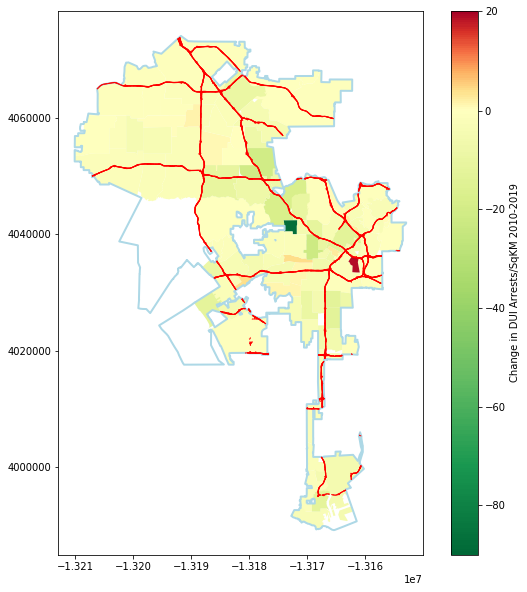

In [86]:
# Plotting change in DUI's per SqKm from 2010 to 2019
ax = city.geometry.boundary.plot(figsize=(10, 10),color=None,edgecolor='lightblue',linewidth = 2)
neighborhoods_populated.plot(column='Change_2010-2019',ax=ax, norm=divnorm, cmap="RdYlGn_r", legend=True, legend_kwds={'label': "Change in DUI Arrests/SqKM 2010-2019"})
freeways.geometry.plot(color="Red", linewidth = 1, ax=ax)

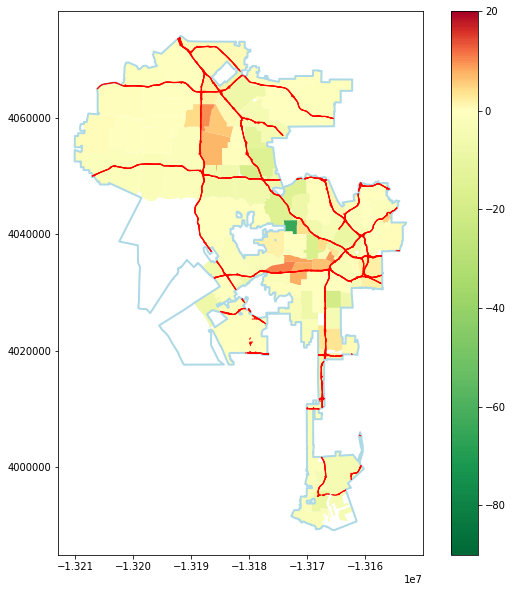

In [87]:
# Plotting change in DUI's per SqKm from 2013 to 2016
ax = city.geometry.boundary.plot(figsize=(10, 10),color=None,edgecolor='lightblue',linewidth = 2)
neighborhoods_populated.plot(column='Change_2013-2016', norm=divnorm, cmap="RdYlGn_r", ax=ax, legend=True)
freeways.geometry.plot(color="Red", linewidth = 1, ax=ax)

In [88]:
# Beer, wine & liquor stores
# Beer, wine, & distilled alcoholic beverage
# |(active_businesses["PRIMARY NAICS DESCRIPTION"] =="Drinking places (alcoholic beverages)")
active_businesses = pd.read_csv("./Listing_of_Active_Businesses.csv")
# Parenthesis in description causing issues. Rename to Bars
active_businesses["PRIMARY NAICS DESCRIPTION"] = active_businesses["PRIMARY NAICS DESCRIPTION"].replace("Drinking places (alcoholic beverages)", "Bars")
active_alcohol_businesses = active_businesses[(active_businesses["PRIMARY NAICS DESCRIPTION"] == "Beer, wine & liquor stores") | (active_businesses["PRIMARY NAICS DESCRIPTION"] == "Beer, wine, & distilled alcoholic beverage") | (active_businesses["PRIMARY NAICS DESCRIPTION"] == "Bars")]
active_alcohol_businesses.head()

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,NAICS,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION
268,0002867779-0001-4,GROUP SHS LLC,RESIDENT,428 S HEWITT STREET,LOS ANGELES,90013-2216,428 HEWITT 90013-2216,428 S HEWITT STREET,LOS ANGELES,90013-2216,722410.0,Bars,14,12/11/2015,NaN,"(34.0428, -118.2352)"
284,0002282290-0001-3,JUAN MANUEL LOPEZ SEGURA,EL NUEVO PARAISO,6711 N FIGUEROA STREET,LOS ANGELES,90042-2007,6711 FIGUEROA 90042-2007,255 N SIERRA BONITA AVENUE,PASADENA,91106-1613,445310.0,"Beer, wine & liquor stores",14,05/01/2007,NaN,"(34.1239, -118.1854)"
300,0003014429-0001-9,YN LIQUOR INC,R & R LIQUOR & JUNIOR MARKET,10509 COMPTON AVENUE,LOS ANGELES,90002-3634,10509 COMPTON 90002-3634,10509 COMPTON AVENUE,LOS ANGELES,90002-3634,445310.0,"Beer, wine & liquor stores",15,10/01/2017,NaN,"(33.9403, -118.2466)"
588,0000005582-0001-4,HITOSH ONO/KINUKO ONO,SUSHI TIME,8103 1/2 BEVERLY BLVD,LOS ANGELES,90048-4507,8103 BEVERLY 90048-4507,NaN,NaN,NaN,722410.0,Bars,5,07/01/2003,NaN,NaN
1263,0002775789-0001-4,S&S BUSINESS INVESTMENT LLC,IRENE'S LIQUOR MARKET,6824 S MAIN STREET,LOS ANGELES,90003-1542,6824 MAIN 90003-1542,NaN,NaN,NaN,445310.0,"Beer, wine & liquor stores",9,09/18/2014,NaN,"(33.9773, -118.2739)"


In [89]:
active_alcohol_businesses['Lat'] = np.nan
active_alcohol_businesses['Long'] = np.nan
active_alcohol_businesses = active_alcohol_businesses.assign(STATE="California")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [90]:
# Null Values in Location column are causing issues for the Split Lat Long function
# Replace them with null island coordinates
values = {'LOCATION': '(0.0, 0.0)'}
active_alcohol_businesses.fillna(value=values, inplace = True)
#values = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
#df.fillna(value=values)

In [91]:
test = active_alcohol_businesses[active_alcohol_businesses["BUSINESS NAME"] == "MARINE WHOLESALE & WAREHOUSE CO"]
test.head()

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,NAICS,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION,Lat,Long,STATE
308811,0000049798-0001-6,MARINE WHOLESALE & WAREHOUSE CO,NaN,727 W CAPITOL DRIVE,SAN PEDRO,90731-1226,727 CAPITOL 90731-1226,727 W CAPITOL DRIVE,SAN PEDRO,90731-1226,424800.0,"Beer, wine, & distilled alcoholic beverage",15,01/01/1979,NaN,"(0.0, 0.0)",NaN,NaN,California


In [92]:
active_alcohol_businesses = active_alcohol_businesses.apply(split_lat_long, args=("LOCATION",), axis = 1)
#dui_arrest_data = dui_arrest_data.apply(split_lat_long, args=("Location",), axis = 1)


In [93]:
null_liquor_stores = active_alcohol_businesses[active_alcohol_businesses["LOCATION"] == '(0.0, 0.0)']
null_liquor_stores = null_liquor_stores.apply(get_lat_long, args=("STREET ADDRESS", "CITY", "STATE"), axis = 1)
null_liquor_stores.head()

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,NAICS,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION,Lat,Long,STATE
588,0000005582-0001-4,HITOSH ONO/KINUKO ONO,SUSHI TIME,8103 1/2 BEVERLY BLVD,LOS ANGELES,90048-4507,8103 BEVERLY 90048-4507,NaN,NaN,NaN,722410.0,Bars,5,07/01/2003,NaN,"(0.0, 0.0)",34.076157,-118.366189,California
139336,0003168794-0001-2,PM ASSET MANAGEMENT LLC,SOOPSOK KARAOKE & RESTAURANT,4070 W 3RD STREET,LOS ANGELES,90020-3185,4070 3RD 90020-3185,310 S KINGSLEY DRIVE,LOS ANGELES,90020-3410,722410.0,Bars,0,01/01/2020,NaN,"(0.0, 0.0)",34.068699,-118.302507,California
140244,0002992103-0001-1,"ES OKAY, LLC",PSYCHIC WINE,2825 BELLEVUE AVENUE,LOS ANGELES,90026-,2825 BELLEVUE 90026-,2342 W AVENUE 31,LOS ANGELES,90065-2028,445310.0,"Beer, wine & liquor stores",13,12/17/2016,NaN,"(0.0, 0.0)",34.076767,-118.275451,California
250322,0002391654-0002-2,LUSABER LALAYAN,STOP & SHOP MARKET,1123 N VINE STREET #13,LOS ANGELES,90038-1670,1123 VINE 90038-1670,NaN,NaN,NaN,445310.0,"Beer, wine & liquor stores",13,07/01/2009,NaN,"(0.0, 0.0)",34.091388,-118.326648,California
251852,0002439228-0001-4,SSQUARED LLC,NaN,110 E 9TH STREET LOBBY #A2,LOS ANGELES,90079-1102,110 9TH 90079-1102,1034 E ORANGE GROVE AVENUE,BURBANK,91501-1432,445310.0,"Beer, wine & liquor stores",14,05/12/2009,NaN,"(0.0, 0.0)",34.041339,-118.254813,California


In [94]:
# Select all the rows where the location was not null island
active_alcohol_businesses[active_alcohol_businesses["LOCATION"] != '(0.0, 0.0)']
# Append geocoded records
active_alcohol_businesses.append(null_liquor_stores)

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,NAICS,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION,Lat,Long,STATE
268,0002867779-0001-4,GROUP SHS LLC,RESIDENT,428 S HEWITT STREET,LOS ANGELES,90013-2216,428 HEWITT 90013-2216,428 S HEWITT STREET,LOS ANGELES,90013-2216,722410.0,Bars,14,12/11/2015,NaN,"(34.0428, -118.2352)",34.042800,-118.235200,California
284,0002282290-0001-3,JUAN MANUEL LOPEZ SEGURA,EL NUEVO PARAISO,6711 N FIGUEROA STREET,LOS ANGELES,90042-2007,6711 FIGUEROA 90042-2007,255 N SIERRA BONITA AVENUE,PASADENA,91106-1613,445310.0,"Beer, wine & liquor stores",14,05/01/2007,NaN,"(34.1239, -118.1854)",34.123900,-118.185400,California
300,0003014429-0001-9,YN LIQUOR INC,R & R LIQUOR & JUNIOR MARKET,10509 COMPTON AVENUE,LOS ANGELES,90002-3634,10509 COMPTON 90002-3634,10509 COMPTON AVENUE,LOS ANGELES,90002-3634,445310.0,"Beer, wine & liquor stores",15,10/01/2017,NaN,"(33.9403, -118.2466)",33.940300,-118.246600,California
588,0000005582-0001-4,HITOSH ONO/KINUKO ONO,SUSHI TIME,8103 1/2 BEVERLY BLVD,LOS ANGELES,90048-4507,8103 BEVERLY 90048-4507,NaN,NaN,NaN,722410.0,Bars,5,07/01/2003,NaN,"(0.0, 0.0)",NaN,NaN,California
1263,0002775789-0001-4,S&S BUSINESS INVESTMENT LLC,IRENE'S LIQUOR MARKET,6824 S MAIN STREET,LOS ANGELES,90003-1542,6824 MAIN 90003-1542,NaN,NaN,NaN,445310.0,"Beer, wine & liquor stores",9,09/18/2014,NaN,"(33.9773, -118.2739)",33.977300,-118.273900,California
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366298,0002469822-0001-5,JONATHAN VALDIVIA & INEZ T MORIN,CLOUD 9,9 ITATI TRAIL,CHATSWORTH,91311-,9 ITATI TRAIL 91311-,POST OFFICE BOX #921825,SYLMAR,91392-1825,445310.0,"Beer, wine & liquor stores",0,11/04/2009,NaN,"(0.0, 0.0)",34.257250,-118.591010,California
399330,0003160944-0001-2,RBRPB LLC,CLUB TEMPO,5520 SANTA MONICA BLVD #105,LOS ANGELES,90038-4089,5520 SANTA MONICA 90038-4089,4821 LANKERSHIM BLVD #F115,NORTH HOLLYWOOD,91601-4538,722410.0,Bars,2,11/11/2019,NaN,"(0.0, 0.0)",34.090743,-118.310373,California
403506,0003133725-0001-6,1987 JUICES,NaN,6600 TOPANGA CANYON BLVD,CANOGA PARK,91303-2609,6600 TOPANGA CANYON 91303-2609,5609 COLFAX AVENUE UNIT #363,NORTH HOLLYWOOD,91601-1702,722410.0,Bars,3,07/01/2019,NaN,"(0.0, 0.0)",34.191132,-118.605867,California
410161,0002770073-0005-2,KAUR ANS CORP,NaN,4217 W 3RD STREET #C,LOS ANGELES,90020-3487,4217 3RD 90020-3487,NaN,NaN,NaN,445310.0,"Beer, wine & liquor stores",10,06/01/2018,NaN,"(0.0, 0.0)",34.069017,-118.306328,California


In [95]:
active_alcohol_businesses.columns

Index(['LOCATION ACCOUNT #', 'BUSINESS NAME', 'DBA NAME', 'STREET ADDRESS',
       'CITY', 'ZIP CODE', 'LOCATION DESCRIPTION', 'MAILING ADDRESS',
       'MAILING CITY', 'MAILING ZIP CODE', 'NAICS',
       'PRIMARY NAICS DESCRIPTION', 'COUNCIL DISTRICT', 'LOCATION START DATE',
       'LOCATION END DATE', 'LOCATION', 'Lat', 'Long', 'STATE'],
      dtype='object')

In [96]:
active_alcohol_businesses = active_alcohol_businesses.apply(convert_lat_long_to_float, axis = 1)
active_alcohol_gdf = gpd.GeoDataFrame(
    active_alcohol_businesses, geometry=gpd.points_from_xy(active_alcohol_businesses.Long, active_alcohol_businesses.Lat))
active_alcohol_gdf.crs = {'init' :'epsg:4326'}
active_alcohol_gdf = active_alcohol_gdf.to_crs({'init': 'epsg:3857'})

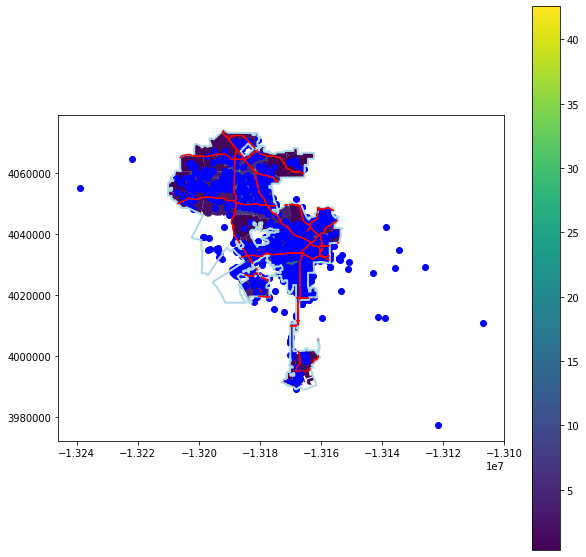

In [97]:
ax = city.geometry.boundary.plot(figsize=(10, 10),color=None,edgecolor='lightblue',linewidth = 2)
neighborhoods_populated.plot(column='2019', ax=ax, legend=True)
freeways.geometry.plot(color="Red", linewidth = 1, ax=ax)
active_alcohol_gdf.plot(color="Blue", ax=ax)

In [98]:
active_alcohol_gdf.columns

Index(['LOCATION ACCOUNT #', 'BUSINESS NAME', 'DBA NAME', 'STREET ADDRESS',
       'CITY', 'ZIP CODE', 'LOCATION DESCRIPTION', 'MAILING ADDRESS',
       'MAILING CITY', 'MAILING ZIP CODE', 'NAICS',
       'PRIMARY NAICS DESCRIPTION', 'COUNCIL DISTRICT', 'LOCATION START DATE',
       'LOCATION END DATE', 'LOCATION', 'Lat', 'Long', 'STATE', 'geometry'],
      dtype='object')

In [99]:
# Get count of liquor stores per neighborhood
# Perform Spatial Join between Liquor Stores and Neighborhoods
# Count totals of NC field in Liquor Store DF
# Join totals to NC DF
active_alcohol_gdf = gpd.sjoin(active_alcohol_gdf, neighborhoods_populated, how='left', op='intersects', lsuffix='left', rsuffix='right')
active_alcohol_gdf = active_alcohol_gdf.rename(columns={"2012": "Twenty_Twelve"})
active_alcohol_gdf = active_alcohol_gdf[active_alcohol_gdf.Twenty_Twelve.notnull()]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:3857'} != None)
  "(%s != %s)" % (left_df.crs, right_df.crs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


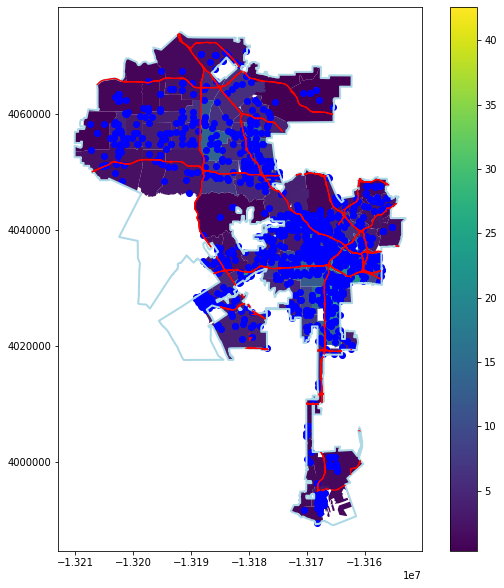

In [100]:
ax = city.geometry.boundary.plot(figsize=(10, 10),color=None,edgecolor='lightblue',linewidth = 2)
neighborhoods_populated.plot(column='2019', ax=ax, legend=True)
freeways.geometry.plot(color="Red", linewidth = 1, ax=ax)
active_alcohol_gdf.plot(color="Blue", ax=ax)

In [101]:
active_alcohol_gdf.columns

Index(['LOCATION ACCOUNT #', 'BUSINESS NAME', 'DBA NAME', 'STREET ADDRESS',
       'CITY', 'ZIP CODE', 'LOCATION DESCRIPTION', 'MAILING ADDRESS',
       'MAILING CITY', 'MAILING ZIP CODE', 'NAICS',
       'PRIMARY NAICS DESCRIPTION', 'COUNCIL DISTRICT', 'LOCATION START DATE',
       'LOCATION END DATE', 'LOCATION', 'Lat', 'Long', 'STATE', 'geometry',
       'index_right', 'OBJECTID', 'NAME', 'WADDRESS', 'DWEBSITE', 'DEMAIL',
       'DPHONE', 'NC_ID', 'CERTIFIED', 'TOOLTIP', 'NLA_URL', 'SERVICE_RE',
       'Area', '2010', '2011', 'Twenty_Twelve', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', 'Change_2010-2019', 'Change_2013-2016'],
      dtype='object')

In [102]:
Alcohol_Store_Count = active_alcohol_gdf.NC_ID.value_counts()
Alcohol_Store_Count.head()

52.0    60
55.0    42
50.0    35
24.0    28
68.0    28
Name: NC_ID, dtype: int64

In [103]:
neighborhoods_populated = neighborhoods_populated.join(Alcohol_Store_Count, on = "NC_ID", how = "left", rsuffix="rt")
neighborhoods_populated = neighborhoods_populated.rename(columns={"NC_IDrt": "Alcohol_Store_Count"})


In [104]:
neighborhoods_populated["Alcohol_Store_Density"] = neighborhoods_populated["Alcohol_Store_Count"] / neighborhoods_populated["Area"]
#neighborhoods_populated.dtypes

In [105]:
#neighborhoods_populated[neighborhoods_populated["NC_ID"] == 50]
neighborhoods_populated.columns

Index(['OBJECTID', 'NAME', 'WADDRESS', 'DWEBSITE', 'DEMAIL', 'DPHONE', 'NC_ID',
       'CERTIFIED', 'TOOLTIP', 'NLA_URL', 'SERVICE_RE', 'geometry', 'Area',
       '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
       '2019', 'Change_2010-2019', 'Change_2013-2016', 'Alcohol_Store_Count',
       'Alcohol_Store_Density'],
      dtype='object')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


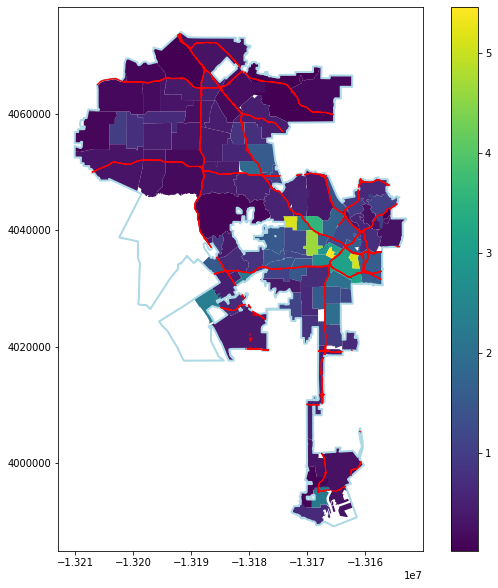

In [106]:
# Map Neighborhoods with Liquor Store per SqKm
ax = city.geometry.boundary.plot(figsize=(10, 10),color=None,edgecolor='lightblue',linewidth = 2)
neighborhoods_populated.plot(column='Alcohol_Store_Density', ax=ax, legend=True)
freeways.geometry.plot(color="Red", linewidth = 1, ax=ax)


In [107]:
#neighborhoods_populated["Liquor_Per_SqKm"] = (neighborhoods_populated['Liquor_Store_Count']/neighborhoods_populated['Area'])
# Liquor Store data is not historic, so calculating ratio of DUI's to Liquor Stores only with 2019 DUI Data.
neighborhoods_populated["DUI_Per_Alcohol_Store"] = (neighborhoods_populated['2019']/neighborhoods_populated["Alcohol_Store_Density"])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


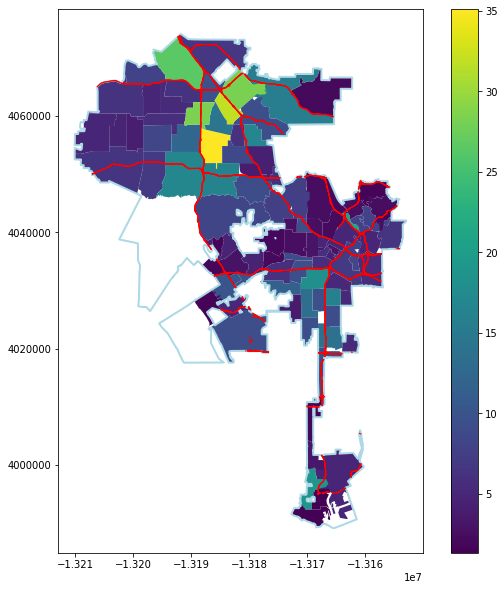

In [108]:
# Map DUI's Per Liquor Store/SqKm
ax = city.geometry.boundary.plot(figsize=(10, 10),color=None,edgecolor='lightblue',linewidth = 2)
neighborhoods_populated.plot(column='DUI_Per_Alcohol_Store', ax=ax, legend=True)
freeways.geometry.plot(color="Red", linewidth = 1, ax=ax)


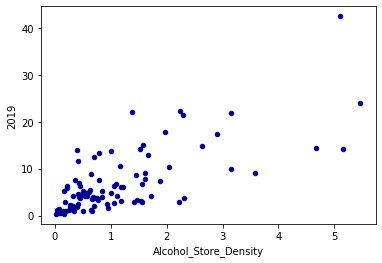

In [109]:
# Convert to Pandas DF to use plot
df1 = pd.DataFrame(neighborhoods_populated)
# Plot 2019 DUI's per SqKm relative to Alcohol Stores per SqKm
df1.plot(x='Alcohol_Store_Density', y='2019', c='DarkBlue', kind = 'scatter')

In [110]:
df1.columns

Index(['OBJECTID', 'NAME', 'WADDRESS', 'DWEBSITE', 'DEMAIL', 'DPHONE', 'NC_ID',
       'CERTIFIED', 'TOOLTIP', 'NLA_URL', 'SERVICE_RE', 'geometry', 'Area',
       '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
       '2019', 'Change_2010-2019', 'Change_2013-2016', 'Alcohol_Store_Count',
       'Alcohol_Store_Density', 'DUI_Per_Alcohol_Store'],
      dtype='object')

In [111]:
# Break Down Trend for Liquor Stores vs. Bars
BarGDF = active_alcohol_gdf[active_alcohol_gdf["PRIMARY NAICS DESCRIPTION"] == "Bars"]
LiquorGDF = active_alcohol_gdf[(active_alcohol_gdf["PRIMARY NAICS DESCRIPTION"] == "Beer, wine & liquor stores") | (active_alcohol_gdf["PRIMARY NAICS DESCRIPTION"] == "Beer, wine, & distilled alcoholic beverage")]

In [112]:
Bar_Count = BarGDF.NC_ID.value_counts()
#Bar_Count.head()
neighborhoods_populated = neighborhoods_populated.join(Bar_Count, on = "NC_ID", how = "left", rsuffix="rt")
neighborhoods_populated = neighborhoods_populated.rename(columns={"NC_IDrt": "Bar_Count"})


In [113]:
Liquor_Count = LiquorGDF.NC_ID.value_counts()
#Bar_Count.head()
neighborhoods_populated = neighborhoods_populated.join(Liquor_Count, on = "NC_ID", how = "left", rsuffix="rt")
neighborhoods_populated = neighborhoods_populated.rename(columns={"NC_IDrt": "Liquor_Count"})


In [114]:
neighborhoods_populated["Bar_Density"] = neighborhoods_populated["Bar_Count"] / neighborhoods_populated["Area"]
neighborhoods_populated["Liquor_Density"] = neighborhoods_populated["Liquor_Count"] / neighborhoods_populated["Area"]


In [115]:
neighborhoods_populated.columns

Index(['OBJECTID', 'NAME', 'WADDRESS', 'DWEBSITE', 'DEMAIL', 'DPHONE', 'NC_ID',
       'CERTIFIED', 'TOOLTIP', 'NLA_URL', 'SERVICE_RE', 'geometry', 'Area',
       '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
       '2019', 'Change_2010-2019', 'Change_2013-2016', 'Alcohol_Store_Count',
       'Alcohol_Store_Density', 'DUI_Per_Alcohol_Store', 'Bar_Count',
       'Liquor_Count', 'Bar_Density', 'Liquor_Density'],
      dtype='object')

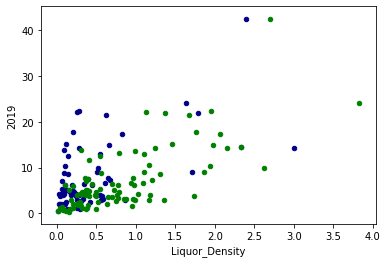

In [116]:
df2 = pd.DataFrame(neighborhoods_populated)
ax = df2.plot(x='Bar_Density', y='2019', c='DarkBlue', kind = 'scatter')
df2.plot(x='Liquor_Density', y='2019', c='Green', kind = 'scatter',  ax=ax)


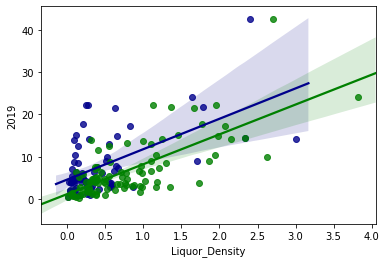

In [117]:
ax = sns.regplot(x="Bar_Density", y="2019", data=df2, color = 'DarkBlue', label="Bars");
sns.regplot(x="Liquor_Density", y="2019", data=df2, color = 'Green', label="Liquor Stores", ax=ax);

In [118]:
# Import NC Census data
# Data on city data portal was bad for Poverty
# Importing geoJSON derived from Census Bureau Data
census = pd.read_csv("./neighborhoods_with_poverty.csv")
census = census.rename(columns={"Estimate!!Total!!Population for whom poverty status is determined": "Pop_With_Poverty_Status", "Estimate!!Below poverty level!!Population for whom poverty status is determined" : "Pop_Below_Poverty_Level"})
census.head()


,Unnamed: 0,OBJECTID,NAME,WADDRESS,DWEBSITE,DEMAIL,DPHONE,NC_ID,CERTIFIED,TOOLTIP,NLA_URL,SERVICE_RE,Pop_With_Poverty_Status,Pop_Below_Poverty_Level,Percent_Below_Poverty
0,0,1,LINCOLN HEIGHTS NC,http://www.lincolnheightsnc.org/,http://empowerla.org/LHNC,LHNC@EmpowerLA.org,213-978-1551,47,2002-04-27T00:00:00.000Z,LINCOLN HEIGHTS NC,navigatela/reports/nc_reports.cfm?id=47,REGION 8 - NORTH EAST LA,30839.048581,7827.344862,0.253813
1,1,2,VOICES OF 90037,https://www.voicesnc.org,https://empowerla.org/voicesof90037/,V9NC@EmpowerLA.org,213-978-1551,109,2008-06-16T00:00:00.000Z,VOICES OF 90037,navigatela/reports/nc_reports.cfm?id=109,REGION 9 - SOUTH LA 2,48057.396084,14624.464831,0.304312
2,2,3,LOS FELIZ NC,http://www.losfeliznc.org/,http://empowerla.org/LFNC,LFNC@EmpowerLA.org,213-978-1551,36,2002-06-11T00:00:00.000Z,LOS FELIZ NC,navigatela/reports/nc_reports.cfm?id=36,REGION 7 - EAST,33515.810847,3732.961423,0.111379
3,3,4,MISSION HILLS NC,http://mhnconline.org/,http://empowerla.org/MHNC,MHNC@EmpowerLA.org,213-978-1551,101,2005-04-19T00:00:00.000Z,MISSION HILLS NC,navigatela/reports/nc_reports.cfm?id=101,REGION 1 - NORTH EAST VALLEY,23229.492691,2928.241633,0.126057
4,4,5,GREATER TOLUCA LAKE NC,http://www.gtlnc.org/,http://empowerla.org/GTLNC,GTLNC@EmpowerLA.org,213-978-1551,28,2002-09-10T00:00:00.000Z,GREATER TOLUCA LAKE NC,navigatela/reports/nc_reports.cfm?id=28,REGION 4 - SOUTH EAST VALLEY,13132.773759,1332.430255,0.101458


In [119]:
# Join Census to NC Shape File
neighborhoods_with_census = neighborhoods_populated.join(census.set_index('NAME'), on = 'NAME', how = "left", rsuffix="rt")
#df.join(other.set_index('key'), on='key')
neighborhoods_with_census

,OBJECTID,NAME,WADDRESS,DWEBSITE,DEMAIL,DPHONE,NC_ID,CERTIFIED,TOOLTIP,NLA_URL,...,DEMAILrt,DPHONErt,NC_IDrt,CERTIFIEDrt,TOOLTIPrt,NLA_URLrt,SERVICE_RErt,Pop_With_Poverty_Status,Pop_Below_Poverty_Level,Percent_Below_Poverty
0,1,LINCOLN HEIGHTS NC,http://www.lincolnheightsnc.org/,http://empowerla.org/LHNC,LHNC@EmpowerLA.org,213-978-1551,47,2002-04-27T00:00:00.000Z,LINCOLN HEIGHTS NC,navigatela/reports/nc_reports.cfm?id=47,...,LHNC@EmpowerLA.org,213-978-1551,47,2002-04-27T00:00:00.000Z,LINCOLN HEIGHTS NC,navigatela/reports/nc_reports.cfm?id=47,REGION 8 - NORTH EAST LA,30839.048581,7827.344862,0.253813
1,2,VOICES OF 90037,https://www.voicesnc.org,https://empowerla.org/voicesof90037/,V9NC@EmpowerLA.org,213-978-1551,109,2008-06-16T00:00:00.000Z,VOICES OF 90037,navigatela/reports/nc_reports.cfm?id=109,...,V9NC@EmpowerLA.org,213-978-1551,109,2008-06-16T00:00:00.000Z,VOICES OF 90037,navigatela/reports/nc_reports.cfm?id=109,REGION 9 - SOUTH LA 2,48057.396084,14624.464831,0.304312
2,3,LOS FELIZ NC,http://www.losfeliznc.org/,http://empowerla.org/LFNC,LFNC@EmpowerLA.org,213-978-1551,36,2002-06-11T00:00:00.000Z,LOS FELIZ NC,navigatela/reports/nc_reports.cfm?id=36,...,LFNC@EmpowerLA.org,213-978-1551,36,2002-06-11T00:00:00.000Z,LOS FELIZ NC,navigatela/reports/nc_reports.cfm?id=36,REGION 7 - EAST,33515.810847,3732.961423,0.111379
3,4,MISSION HILLS NC,http://mhnconline.org/,http://empowerla.org/MHNC,MHNC@EmpowerLA.org,213-978-1551,101,2005-04-19T00:00:00.000Z,MISSION HILLS NC,navigatela/reports/nc_reports.cfm?id=101,...,MHNC@EmpowerLA.org,213-978-1551,101,2005-04-19T00:00:00.000Z,MISSION HILLS NC,navigatela/reports/nc_reports.cfm?id=101,REGION 1 - NORTH EAST VALLEY,23229.492691,2928.241633,0.126057
4,5,GREATER TOLUCA LAKE NC,http://www.gtlnc.org/,http://empowerla.org/GTLNC,GTLNC@EmpowerLA.org,213-978-1551,28,2002-09-10T00:00:00.000Z,GREATER TOLUCA LAKE NC,navigatela/reports/nc_reports.cfm?id=28,...,GTLNC@EmpowerLA.org,213-978-1551,28,2002-09-10T00:00:00.000Z,GREATER TOLUCA LAKE NC,navigatela/reports/nc_reports.cfm?id=28,REGION 4 - SOUTH EAST VALLEY,13132.773759,1332.430255,0.101458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,101,HOLLYWOOD UNITED NC,http://www.hollywoodunitednc.org/,http://empowerla.org/HUNC,HUNC@EmpowerLA.org,213-978-1551,30,2002-10-15T00:00:00.000Z,HOLLYWOOD UNITED NC,navigatela/reports/nc_reports.cfm?id=30,...,HUNC@EmpowerLA.org,213-978-1551,30,2002-10-15T00:00:00.000Z,HOLLYWOOD UNITED NC,navigatela/reports/nc_reports.cfm?id=30,REGION 5 - CENTRAL 1,21082.000598,3243.470859,0.153850
95,102,HERMON NC,https:/www./hermonnc.org/,http://empowerla.org/hnc/,NULL,NULL,126,2017-05-25T00:00:00.000Z,HERMON NC,navigatela/reports/nc_reports.cfm?id=126,...,NaN,NaN,126,2017-05-25T00:00:00.000Z,HERMON NC,navigatela/reports/nc_reports.cfm?id=126,REGION 8 - NORTH EAST LA,4298.501116,725.747283,0.168837
96,103,HISTORIC CULTURAL NC,http://www.hcncla.org/,http://empowerla.org/HCNC,HCNC@EmpowerLA.org,213-978-1551,46,2002-04-27T00:00:00.000Z,HISTORIC CULTURAL NC,navigatela/reports/nc_reports.cfm?id=46,...,HCNC@EmpowerLA.org,213-978-1551,46,2002-04-27T00:00:00.000Z,HISTORIC CULTURAL NC,navigatela/reports/nc_reports.cfm?id=46,REGION 6 - CENTRAL 2,4045.726241,1356.027147,0.335175
97,104,WESTWOOD NC,http://www.wwnc.org/,http://empowerla.org/WWNC,WWNC@EmpowerLA.org,213-978-1551,63,2010-01-19T00:00:00.000Z,WESTWOOD NC,navigatela/reports/nc_reports.cfm?id=63,...,WWNC@EmpowerLA.org,213-978-1551,63,2010-01-19T00:00:00.000Z,WESTWOOD NC,navigatela/reports/nc_reports.cfm?id=63,REGION 11 - WEST LA,25542.291224,3181.801603,0.124570


In [120]:
# Calculate Population Density
neighborhoods_with_census["Pop_Density"] = neighborhoods_with_census["Pop_With_Poverty_Status"] / neighborhoods_with_census["Area"]
#census["Percent_Poverty"] = neighborhoods_with_census["In_Poverty"] / neighborhoods_with_census["Total Population"]
#neighborhoods_with_census["Percent_Rent"] = neighborhoods_with_census["Renter_occ"] / neighborhoods_with_census["Total Population"]
# Compare to Population Density

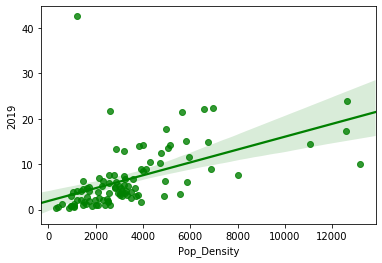

In [121]:
sns.regplot(x="Pop_Density", y="2019", data=neighborhoods_with_census, color = 'Green', label="Population Density");

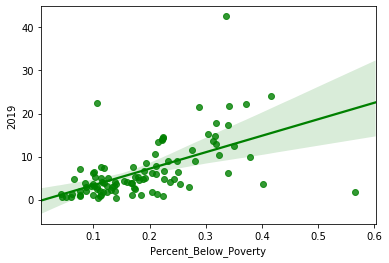

In [122]:
sns.regplot(x="Percent_Below_Poverty", y="2019", data=neighborhoods_with_census, color = 'Green', label="Percent in Poverty");

In [123]:
sns.regplot(x="Percent_Rent", y="2019", data=neighborhoods_with_census, color = 'Green', label="Population Density");

KeyError: 'Percent_Rent'

In [ ]:
#gdf = GeoDataFrame(df, crs=crs, geometry=geometry)
neighborhoods_with_census_gdf = GeoDataFrame(neighborhoods_with_census, geometry = neighborhoods_with_census['geometry'])
neighborhoods_with_census_gdf.columns

In [ ]:
ax = city.geometry.boundary.plot(figsize=(10, 10),color=None,edgecolor='lightblue',linewidth = 2)
neighborhoods_with_census_gdf.plot(column='Percent_Below_Poverty', ax=ax,cmap="RdYlGn_r", legend=True)
freeways.geometry.plot(color="DarkBlue", linewidth = 1, ax=ax)

In [ ]:
ax = city.geometry.boundary.plot(figsize=(10, 10),color=None,edgecolor='lightblue',linewidth = 2)
neighborhoods_with_census_gdf.plot(column='Percent_Rent', ax=ax,cmap="RdYlGn_r", legend=True)
freeways.geometry.plot(color="DarkBlue", linewidth = 1, ax=ax)